# Data Science Coding Challenge

## Overview
### Build a model to predict which patients will be readmitted to hospital within 30 days after discharge.
#### * flagged patients will recieve more comprehensive discharge plan
#### * patients readmitted more than 30 days after discharge are out of scope
#### * readmitted patients within 30 days may result in a fine to hospital.

### Data provided consists of
#### * diabetes_data.csv: A dataset containing the information known for each patient
#### * data_dictionary.csv: Variable definitions for diabetes_data.csv
#### * IDs_mapping.csv: Mappings for numerically coded categorical variablesles

## Strategy
### This a classification problem with 2 classes, to predict whether
#### * class 0: no readmittance/readmittance after 30 days
#### * class 1: readmittance within 30 days

## 0. Load libraries

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
from matplotlib import pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from autogluon.tabular import TabularPredictor as task
import shap
import helper

ModuleNotFoundError: No module named 'autogluon'

## 1. Load and process data
#### Initial data has 50 features and 101,766 encounters.

In [ ]:
# Load dataset
diabetes_df = pd.read_csv("diabetes_data.csv")
diabetes_df.head()

,encounter_id,patient_nbr,race,gender,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admit_date,birth_date
0,2278392,8222157,Caucasian,Female,?,6,25,1,1,?,...,No,No,No,No,No,No,No,NO,2002-10-22 06:30:00,1996-07-29 14:28:00
1,149190,55629189,Caucasian,Female,?,1,1,7,3,?,...,No,No,No,No,No,Ch,Yes,>30,2004-07-24 08:35:00,1985-09-19 11:19:00
2,64410,86047875,AfricanAmerican,Female,?,1,1,7,2,?,...,No,No,No,No,No,No,Yes,NO,2005-11-30 06:35:00,1983-07-14 07:22:00
3,500364,82442376,Caucasian,Male,?,1,1,7,2,?,...,No,No,No,No,No,Ch,Yes,NO,2003-05-26 00:32:00,1968-04-05 23:51:00
4,16680,42519267,Caucasian,Male,?,1,1,7,1,?,...,No,No,No,No,No,Ch,Yes,NO,2004-04-25 04:04:00,1957-11-18 20:30:00


### 1.1 Remove index ids
#### 'encounter_id' and 'patient_nbr' do not contribute to predicting readmittance.

In [ ]:
# Drop index ids
columns = ['encounter_id', 'patient_nbr']
diabetes_df = diabetes_df.drop(columns, axis=1)

### 1.2 Confirm datatypes are correct
#### Numeric values in 'admission_type_id', 'discharge_disposition_id', 'admission_source_id' should be treated as categorical as they serve as mapping ids.

In [ ]:
# Make sure these mapping ids are strings, not numeric.
id_string_types = {'admission_type_id':str, 'discharge_disposition_id' :str , 'admission_source_id' :str}
diabetes_df = diabetes_df.astype(id_string_types)
diabetes_df.dtypes

race                        object
gender                      object
weight                      object
admission_type_id           object
discharge_disposition_id    object
admission_source_id         object
time_in_hospital             int64
payer_code                  object
medical_specialty           object
num_lab_procedures           int64
num_procedures               int64
num_medications              int64
number_outpatient            int64
number_emergency             int64
diag_1                      object
diag_2                      object
diag_3                      object
number_diagnoses             int64
max_glu_serum               object
A1Cresult                   object
metformin                   object
repaglinide                 object
nateglinide                 object
chlorpropamide              object
glimepiride                 object
acetohexamide               object
glipizide                   object
glyburide                   object
tolbutamide         

### 1.3 Remove features with at least 50% missing values
#### Only 'weight' has more than 50% values missing, actually a 96% is missing and so this feature is removed.

In [ ]:
# Drop columns with over 50% missing values
diabetes_df = diabetes_df.replace('?', np.nan)
for column in diabetes_df.columns:
    nan_percent = diabetes_df[column].isna().sum()/len(diabetes_df[column])*100
    if nan_percent > 50.0:
        print("%s has %.2f%% missing values and is dropped" %(column, nan_percent))
        diabetes_df = diabetes_df.drop(column, axis=1)

weight has 96.86% missing values and is dropped


### 1.4 Calculate age from birth date to admit_date
#### Using admission date as a reference, the age of each patient calculated from birth date and add as a new feature called 'age'.

In [ ]:
def calculate_age(birth, admit):
    age = admit.year - birth.year - ((admit.month, admit.day) < (birth.month, birth.day)) 
    return age

In [ ]:
# Calculate age from birth date
diabetes_df['admit_date'] = pd.to_datetime(diabetes_df['admit_date'])
diabetes_df['birth_date'] = pd.to_datetime(diabetes_df['birth_date'])
  
diabetes_df['age'] = diabetes_df.apply(lambda x: calculate_age(x['birth_date'], x['admit_date']), axis=1)             

### 1.5 Remove dates features
#### 'admit_date' and 'birth_date' removed from features since they do not provide contributing power to predicting readmittance.

In [ ]:
# Drop admin_date and birth_date
diabetes_df = diabetes_df.drop(['admit_date', 'birth_date'], axis=1, errors='ignore')

### 1.6 Remove encounters where cause of discharge is expired
#### Hard to get readmitted if deceased.

In [ ]:
# Drop encounters that ended in expired discharges ie. discharge_disposition_id = 11, 19, 20, 21
diabetes_df = diabetes_df[~diabetes_df['discharge_disposition_id'].isin(['11', '19', '20', '21'])]

### 1.7 Visualize distribution of each feature and target
#### 'examide' and 'citoglipton' are removed since these features contain only 1 constant value and do not contribute to predicting readmittance.
#### Visualize any discrepancy or pattern.

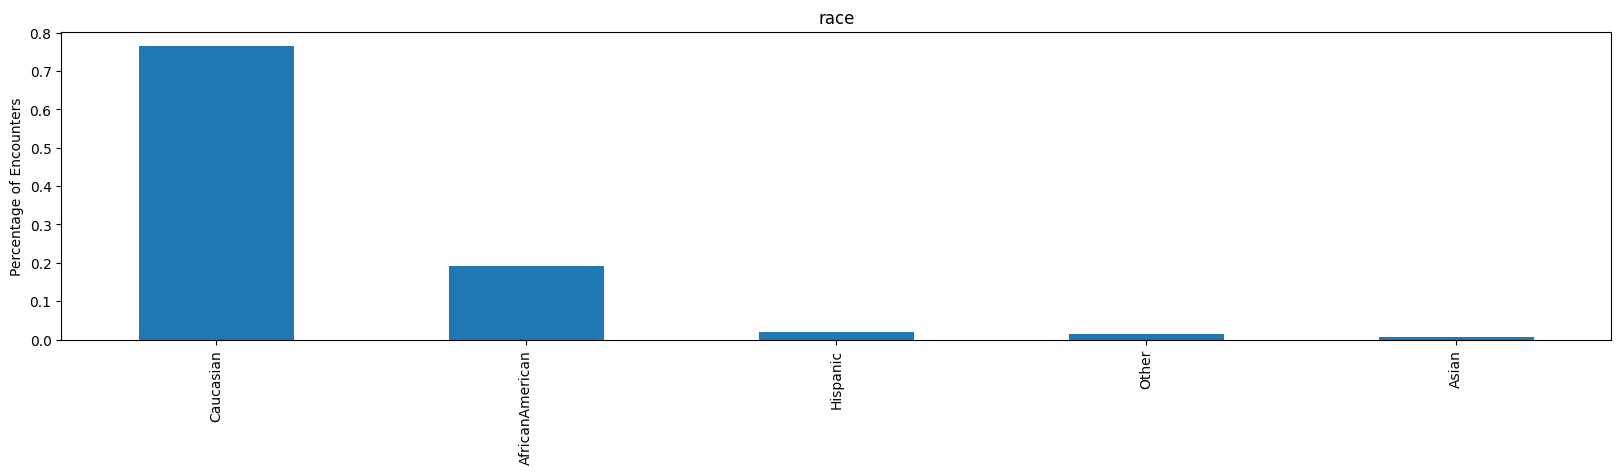

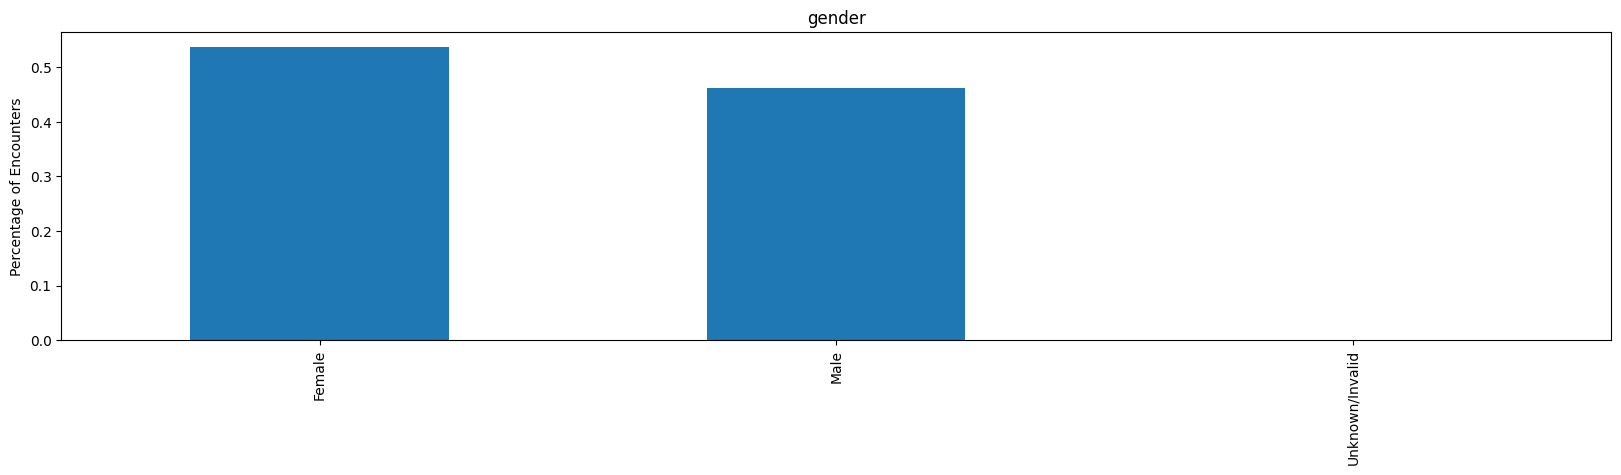

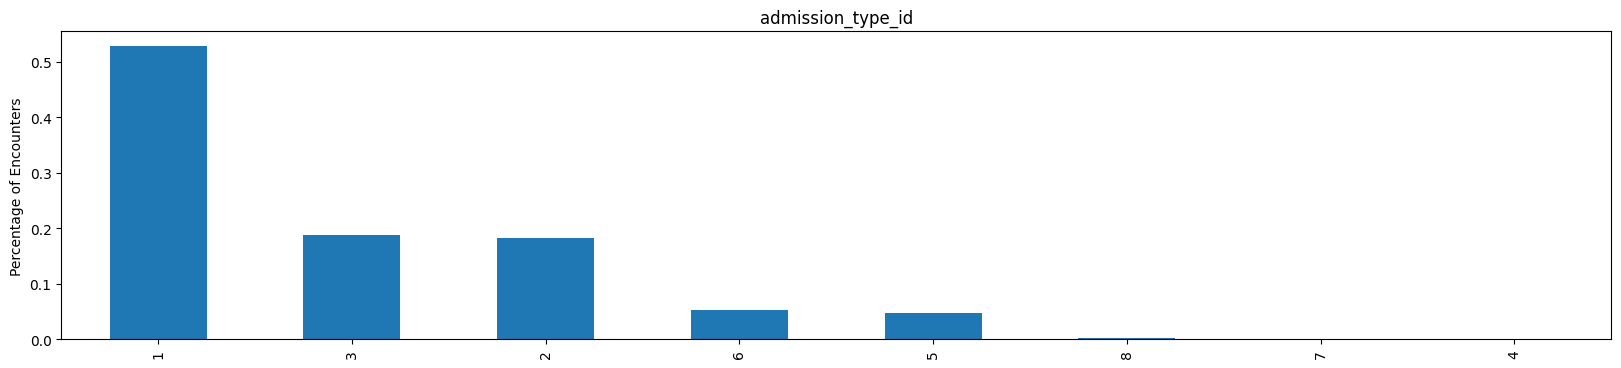

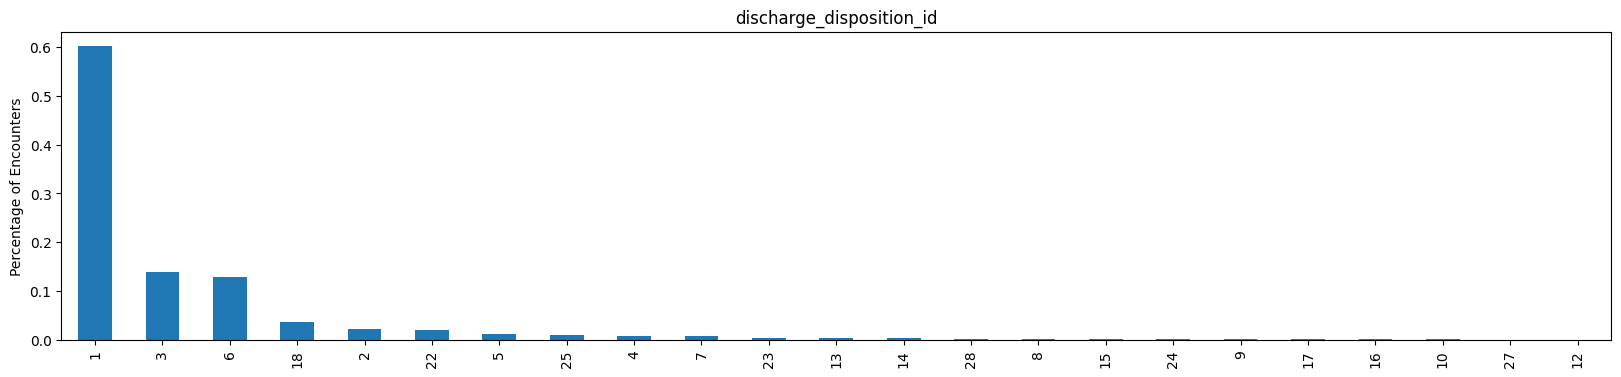

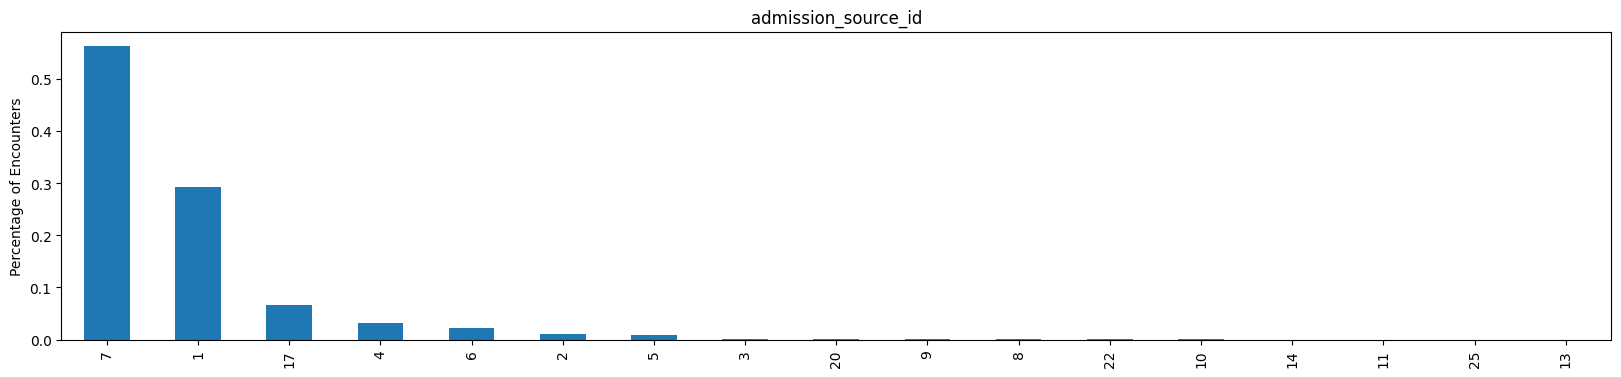

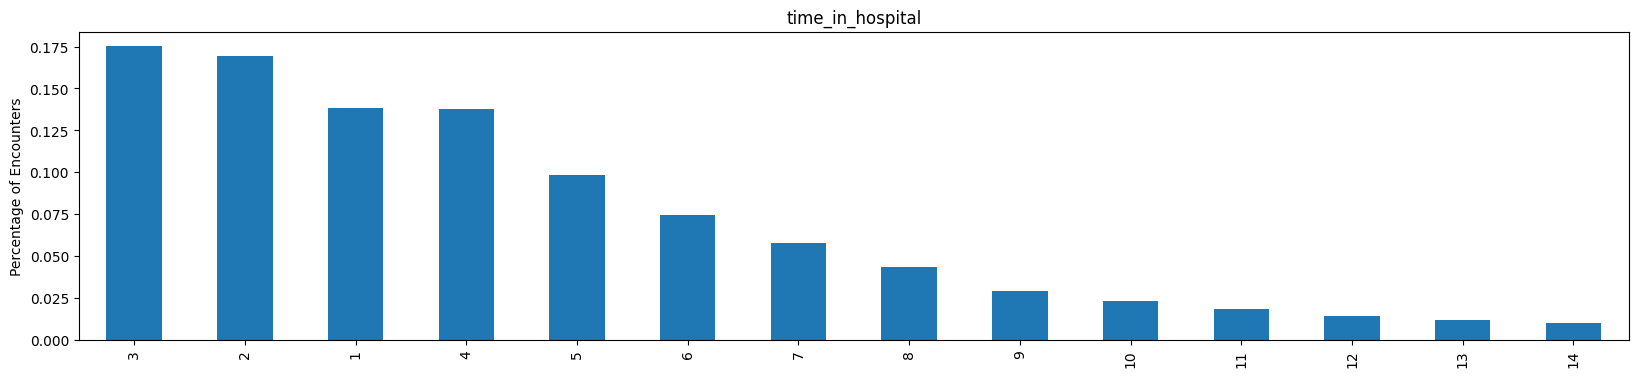

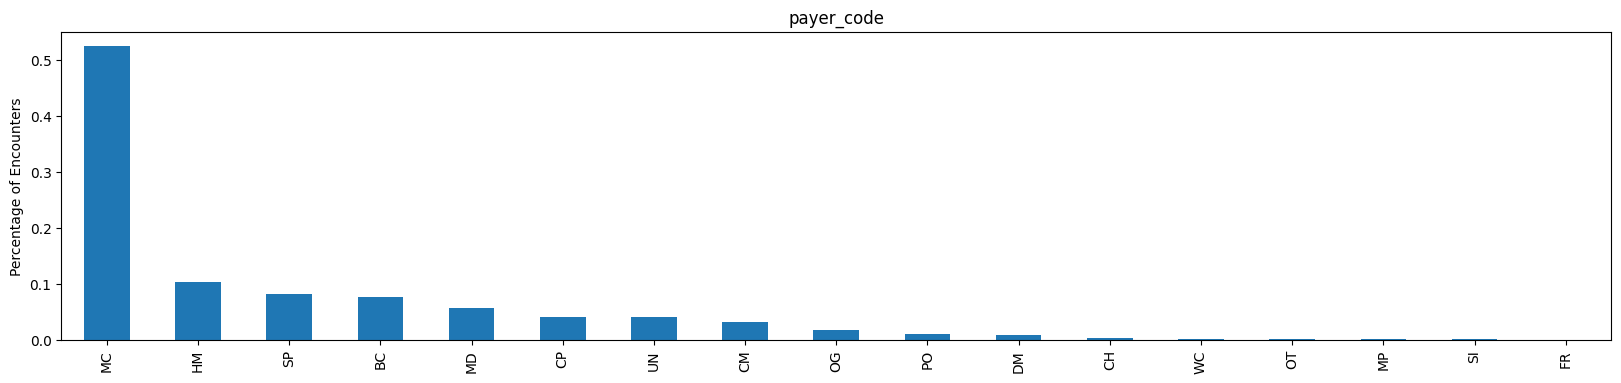

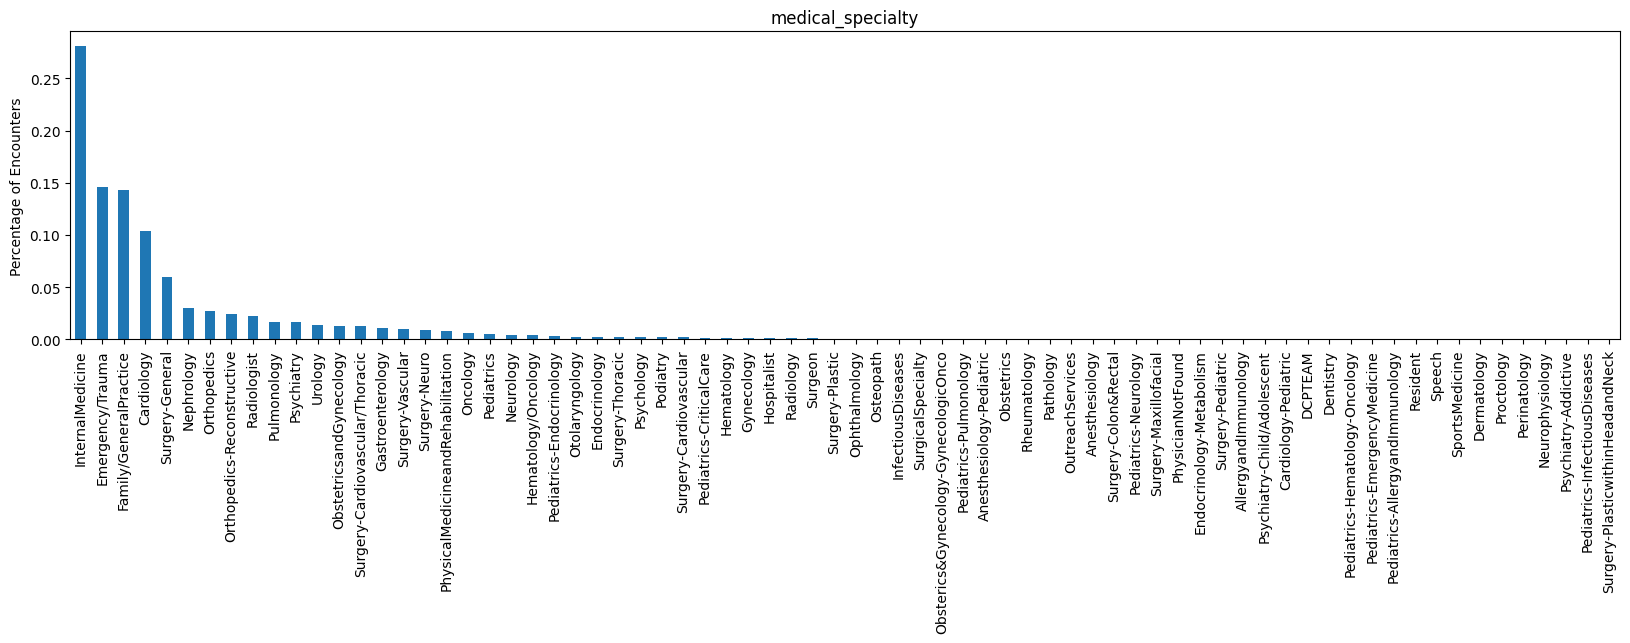

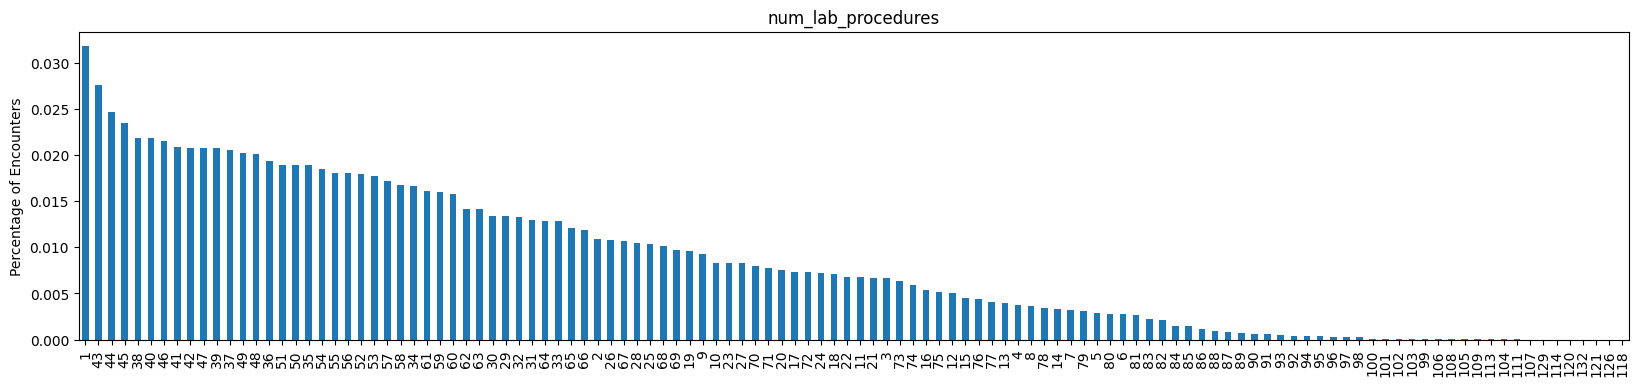

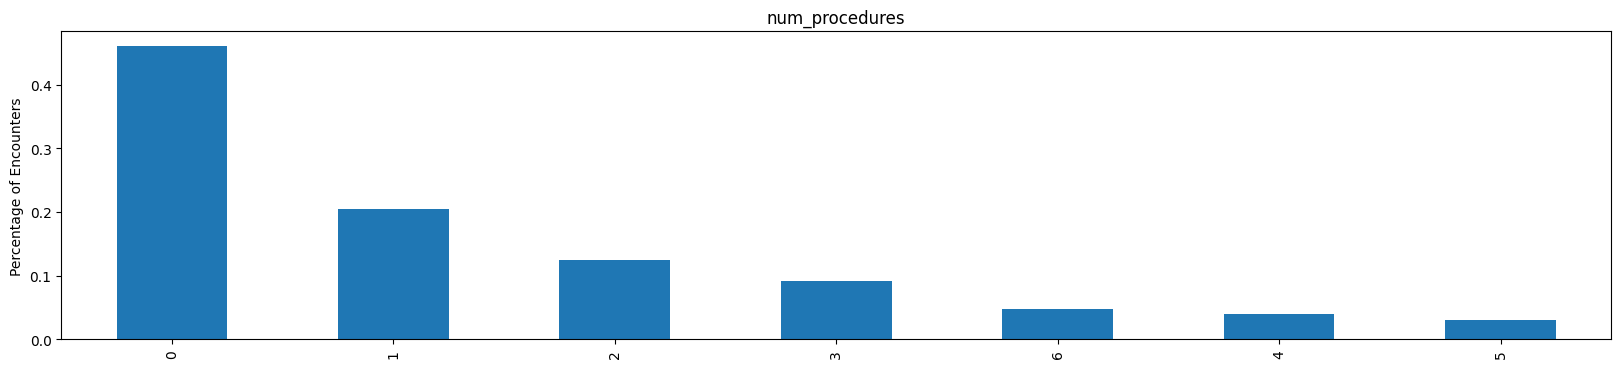

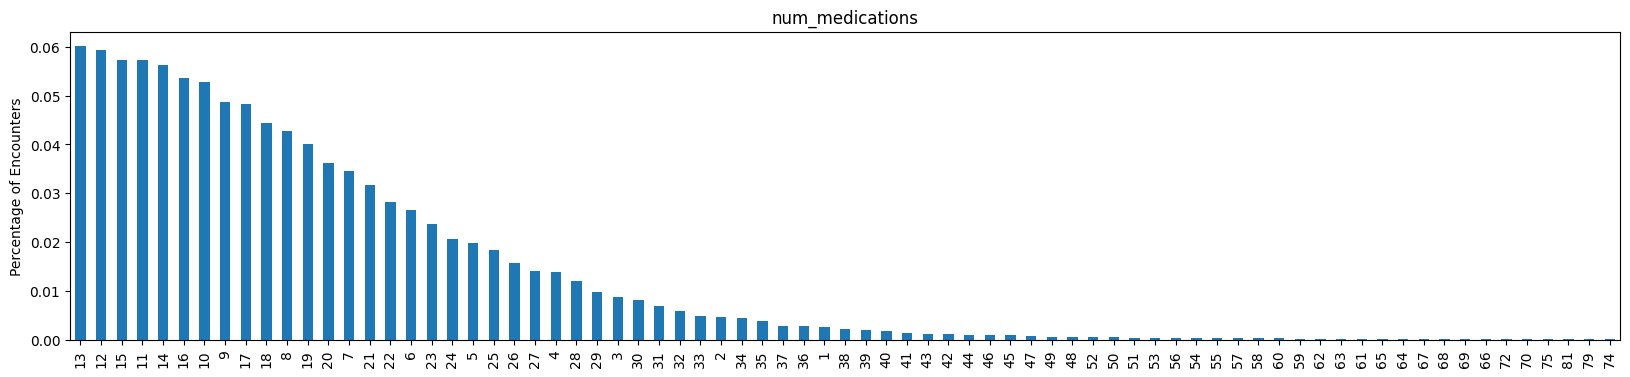

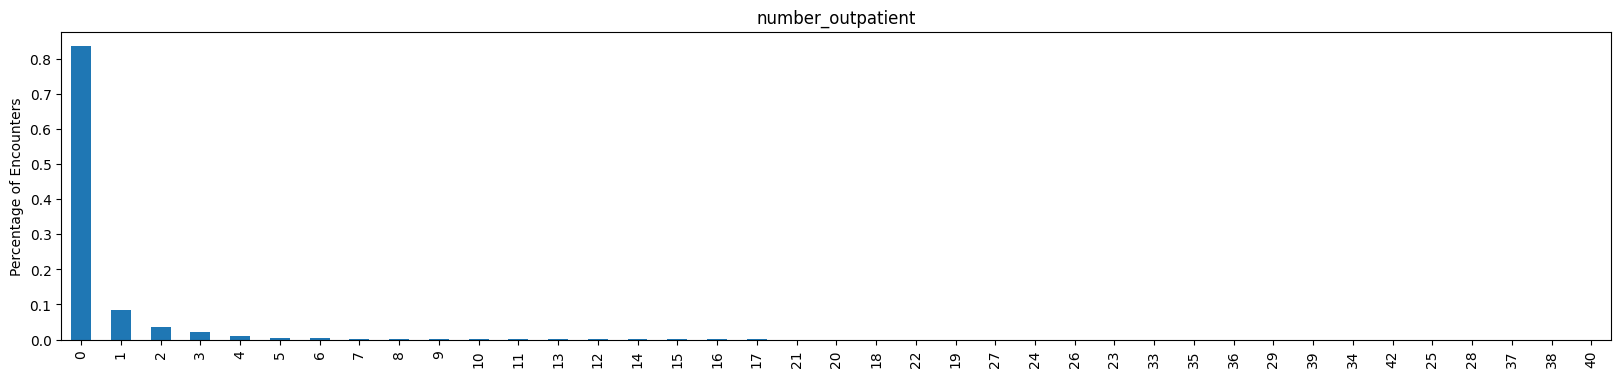

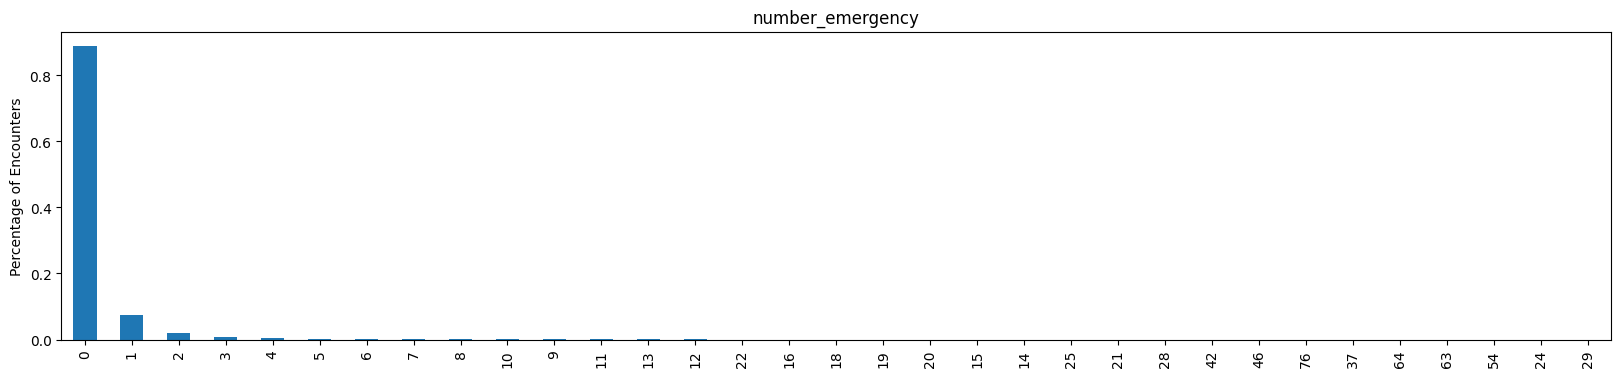

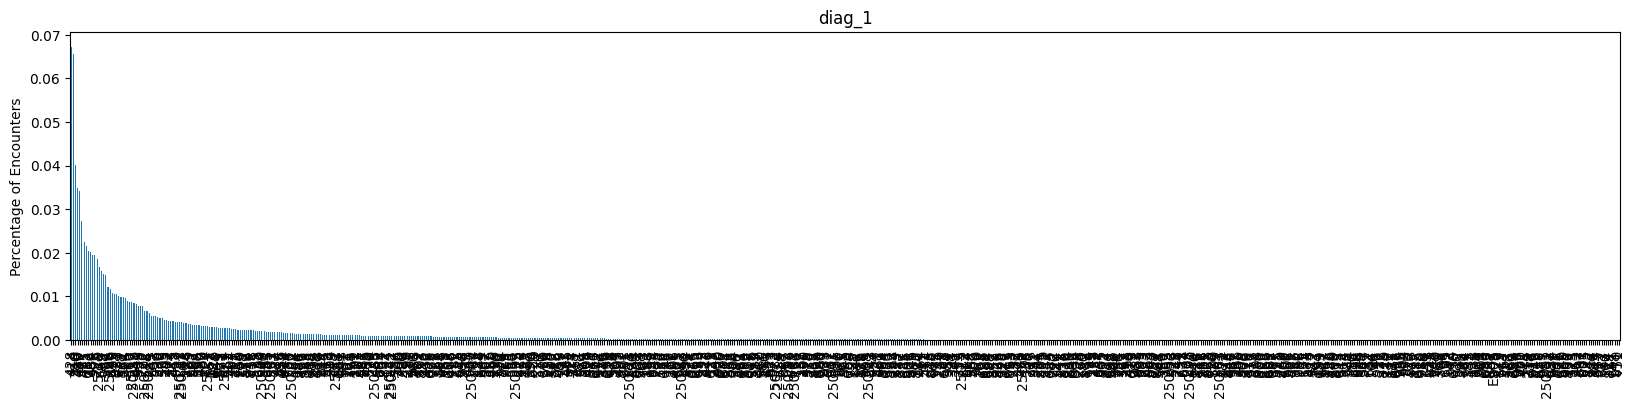

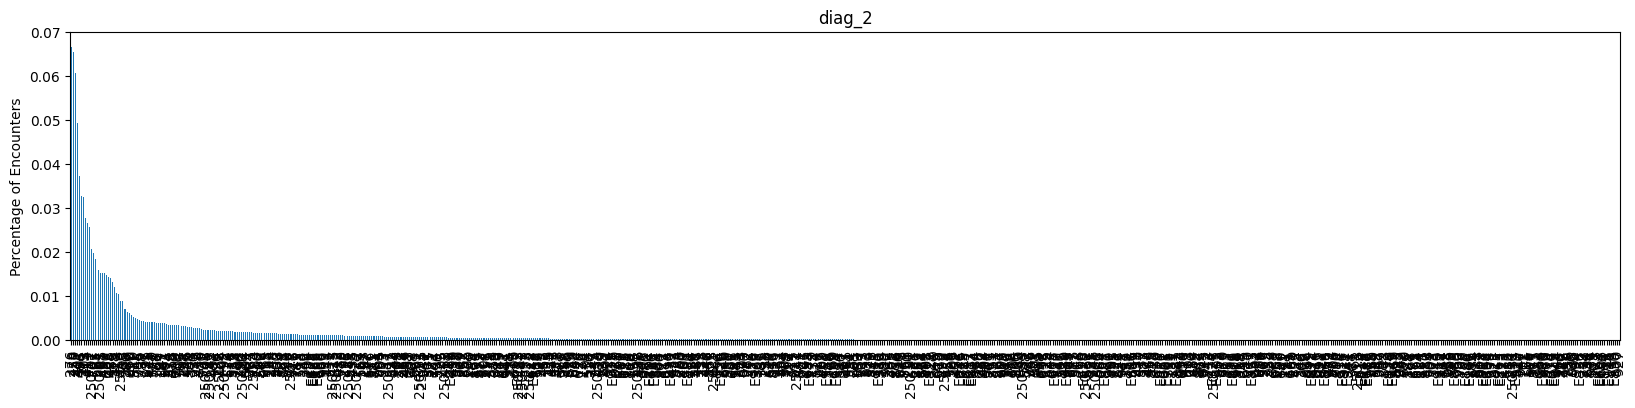

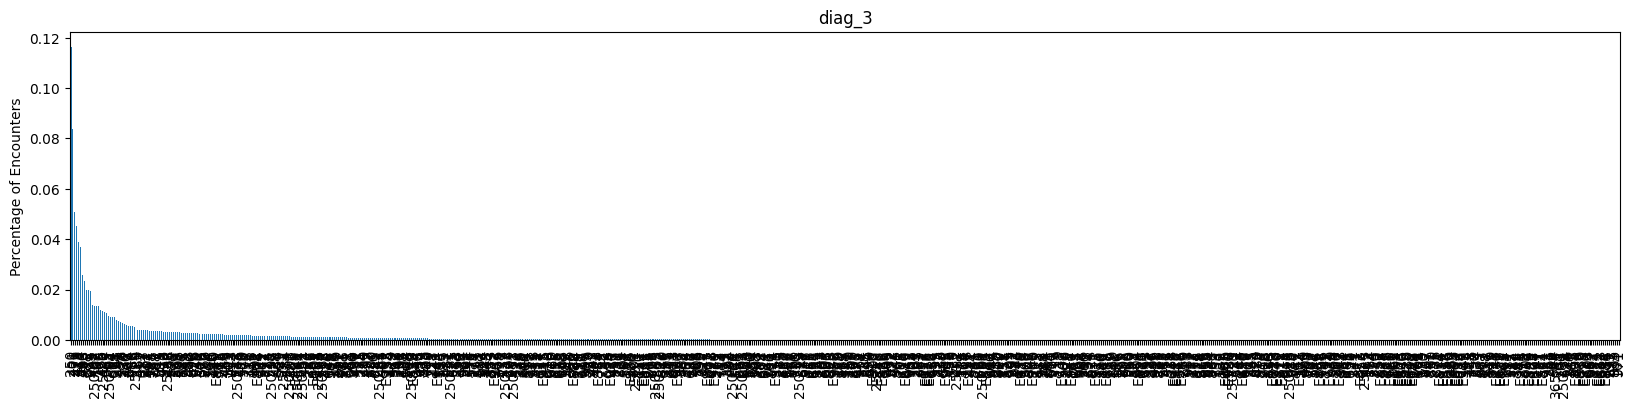

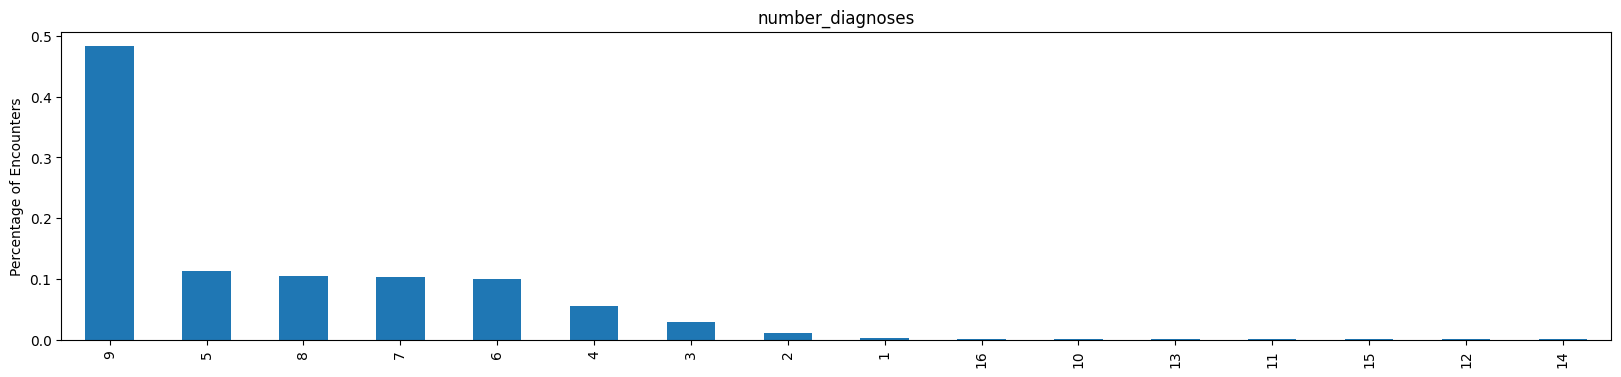

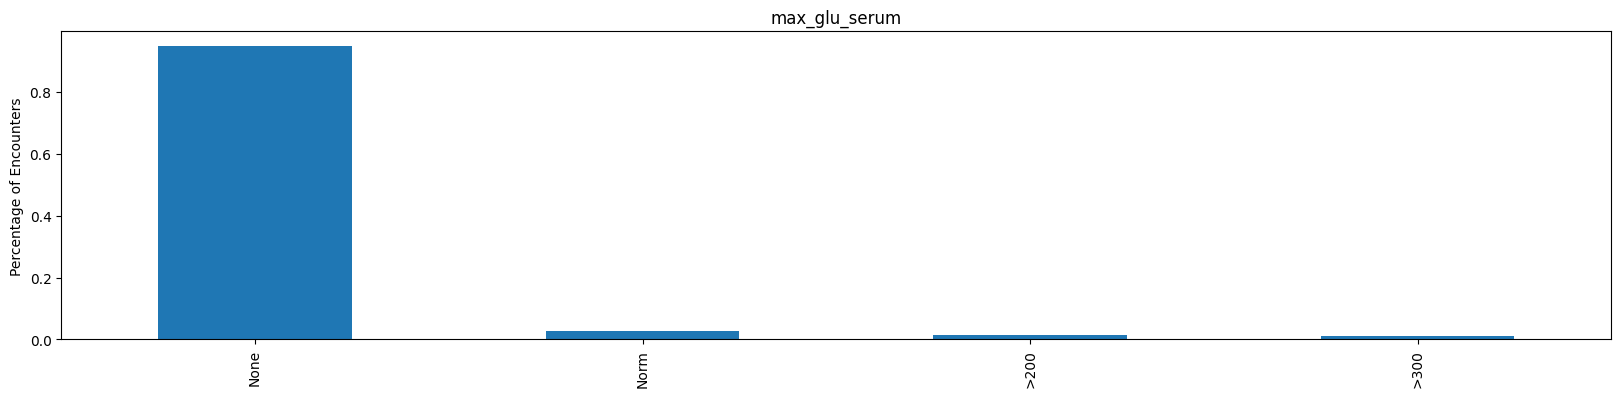

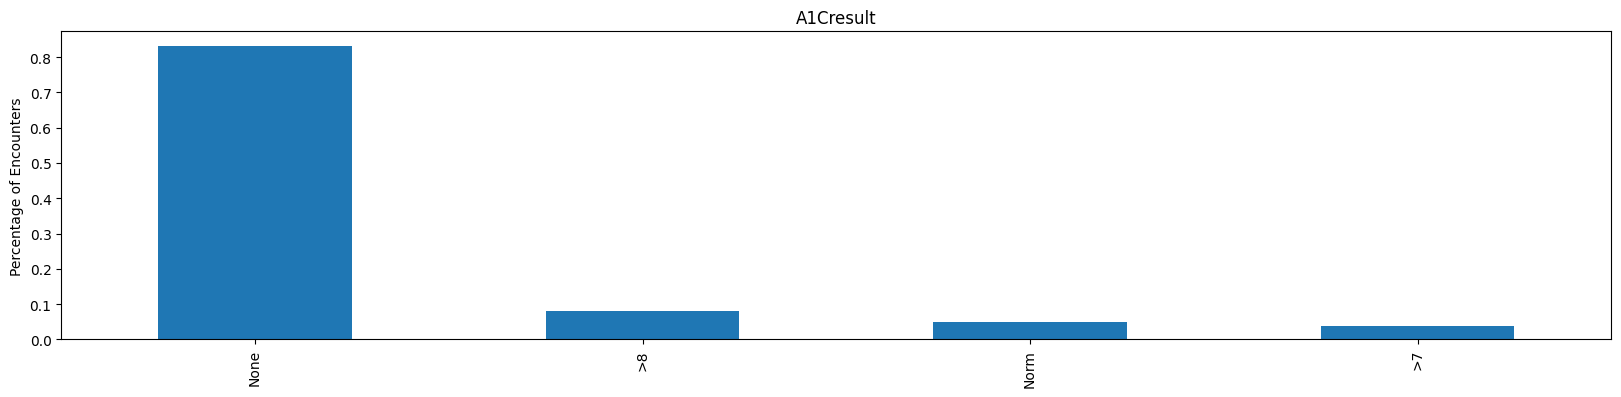

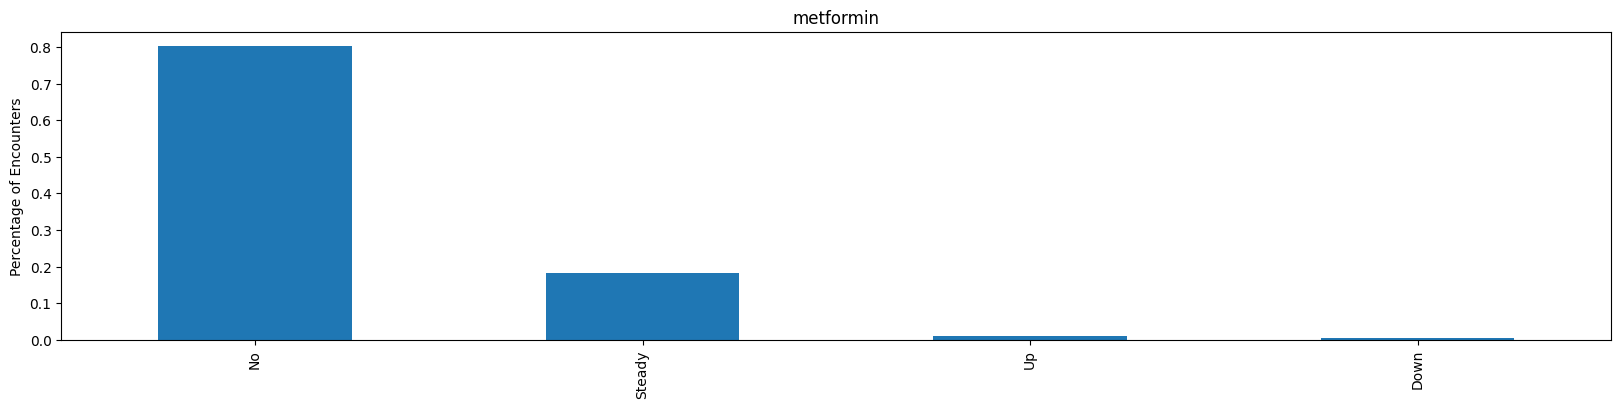

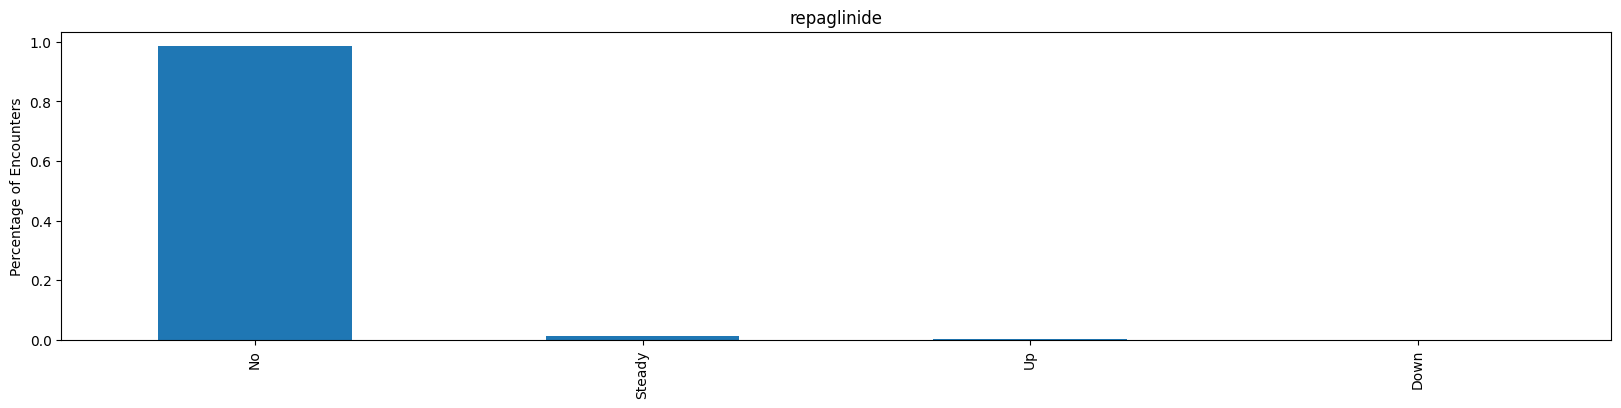

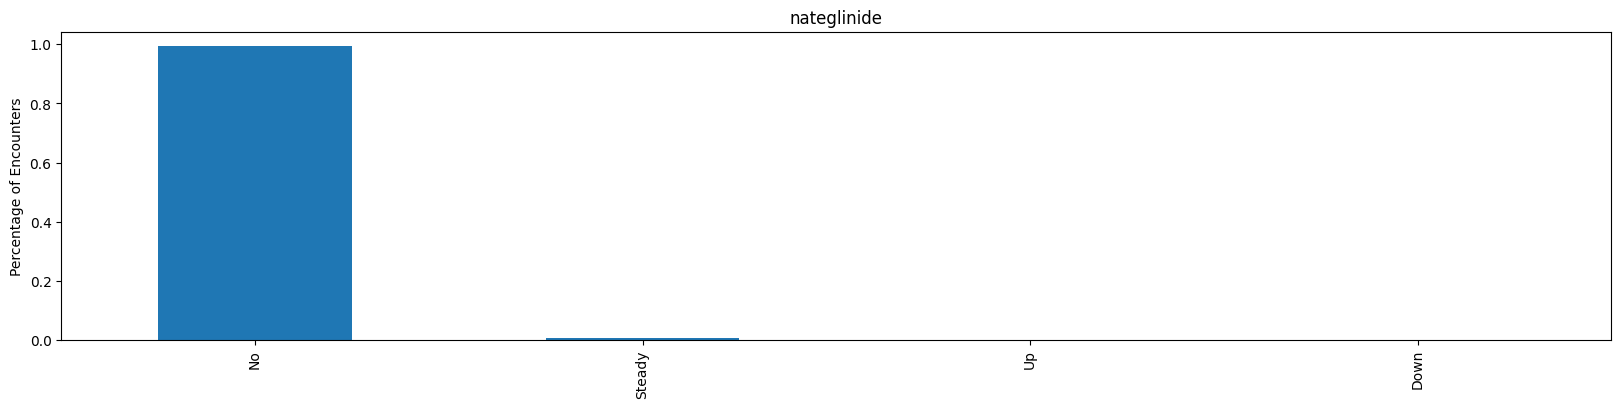

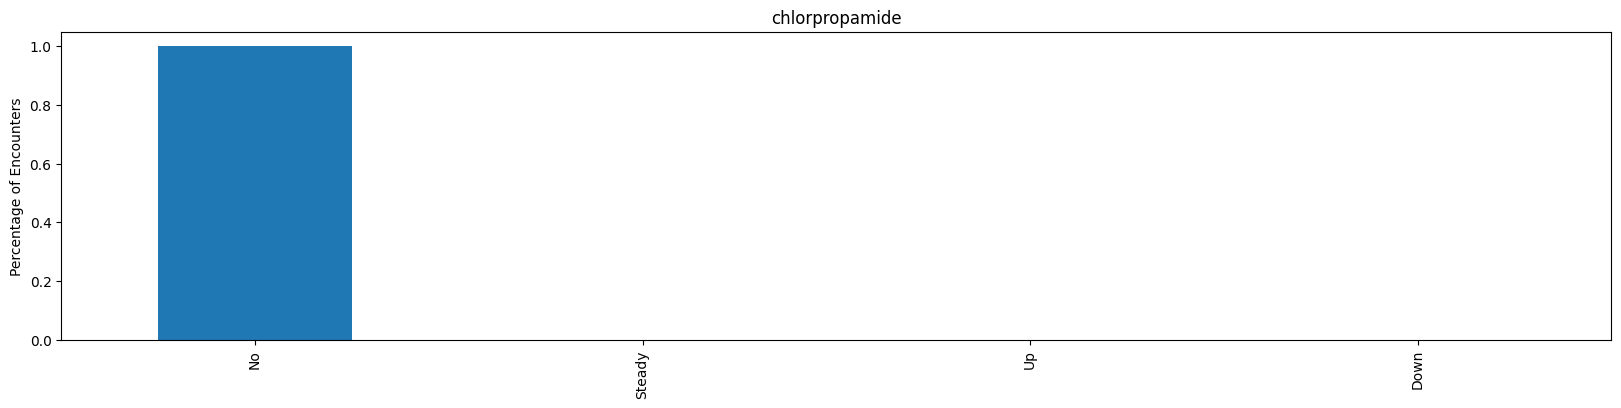

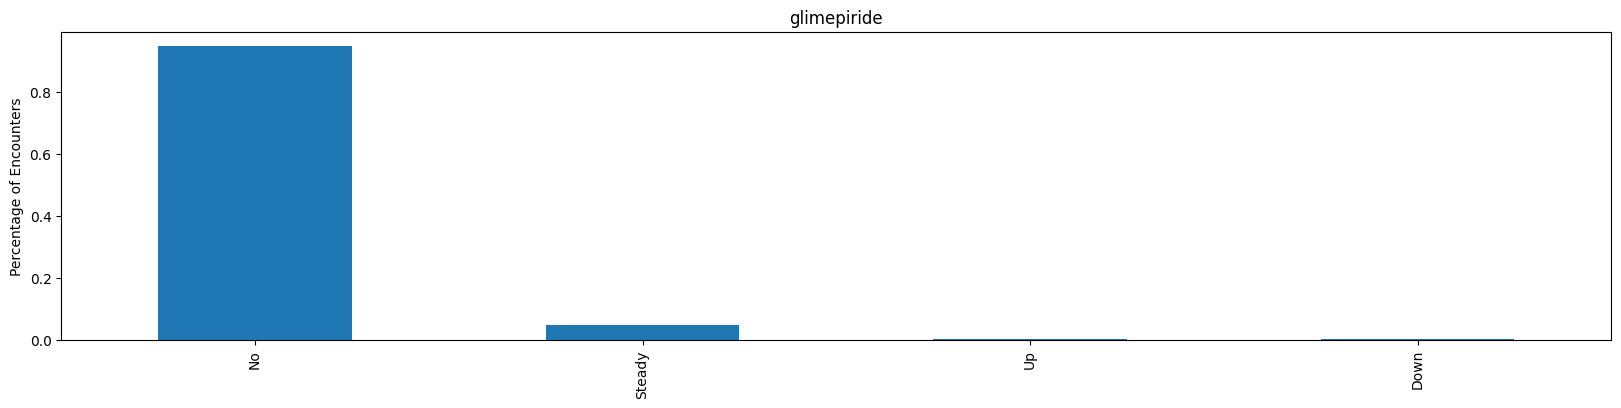

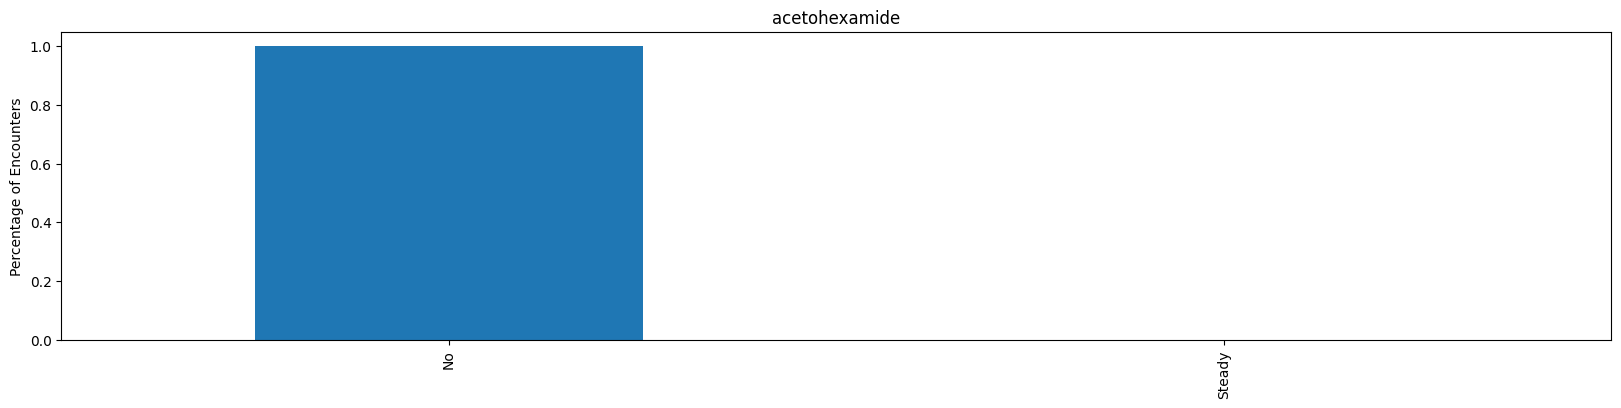

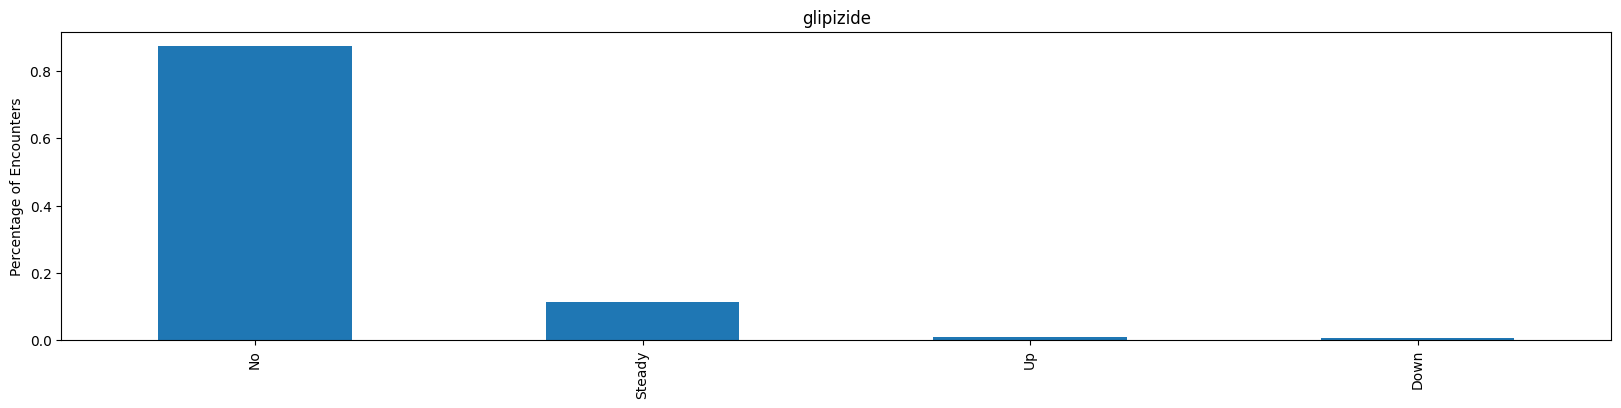

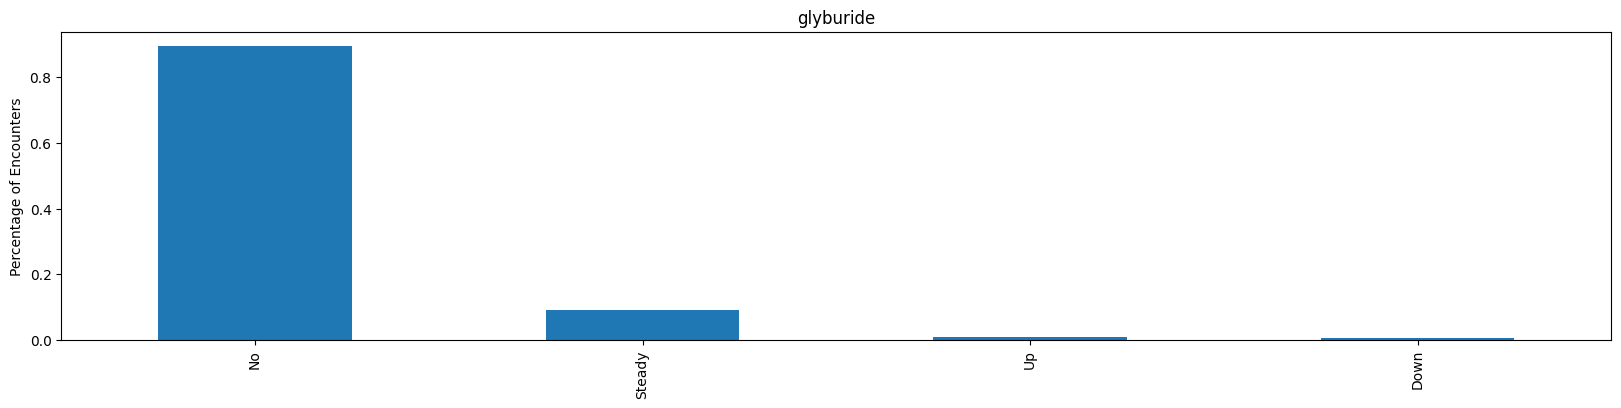

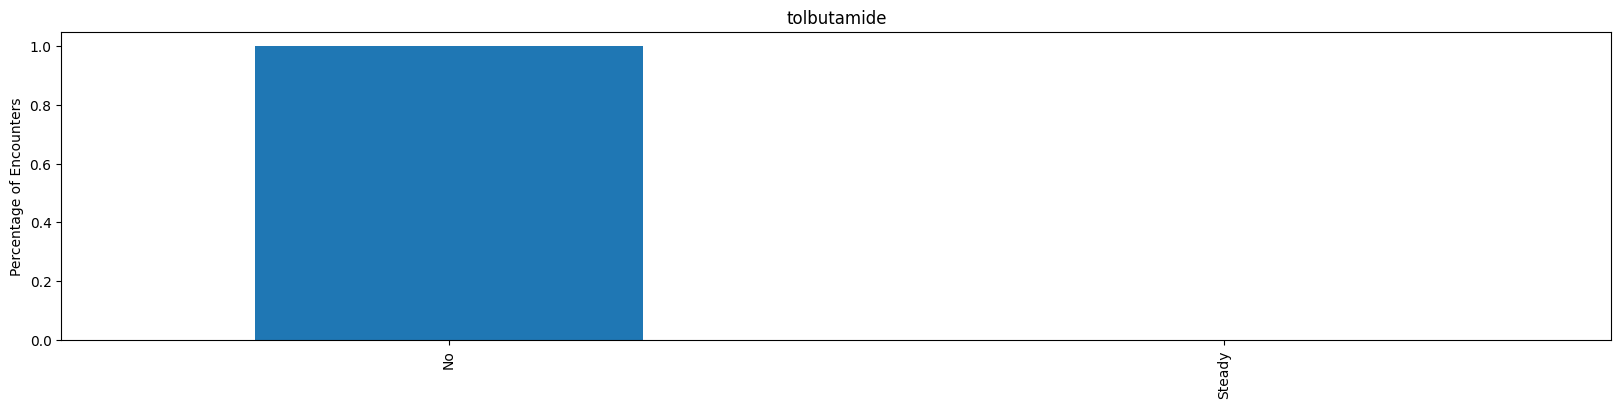

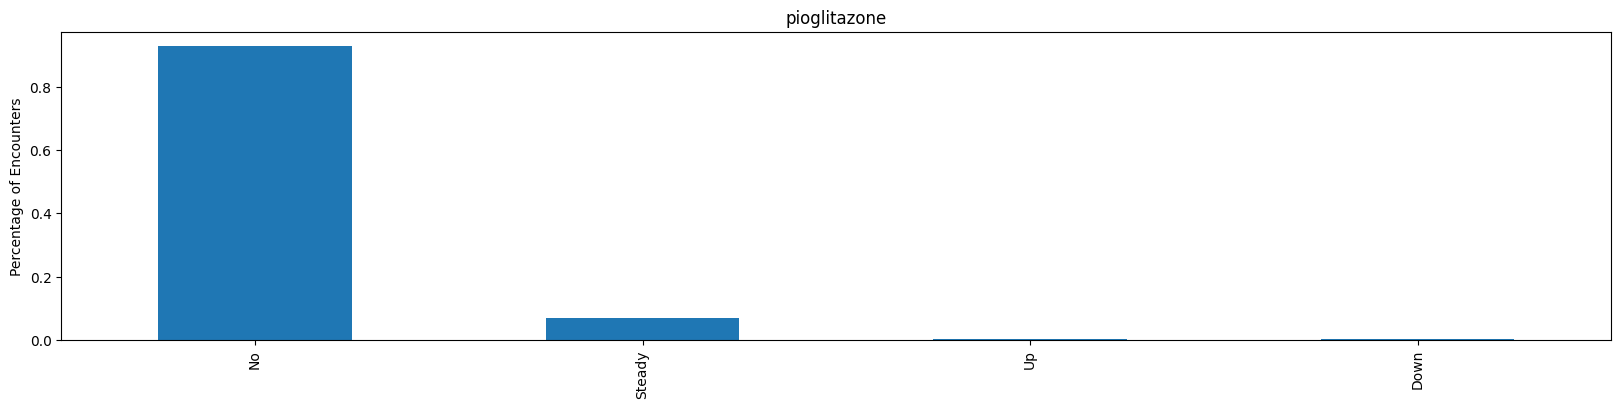

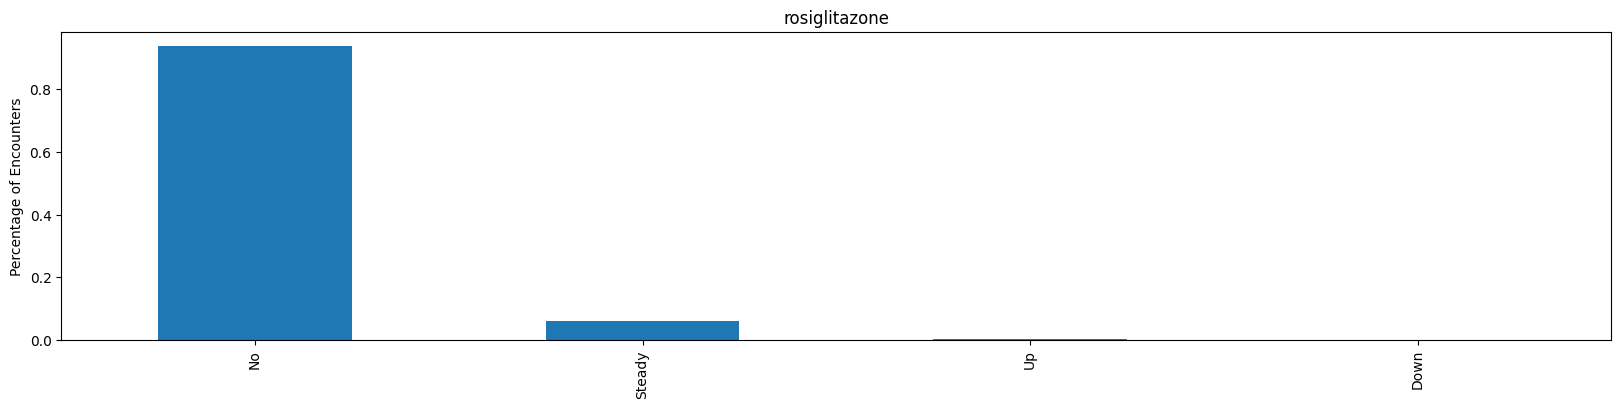

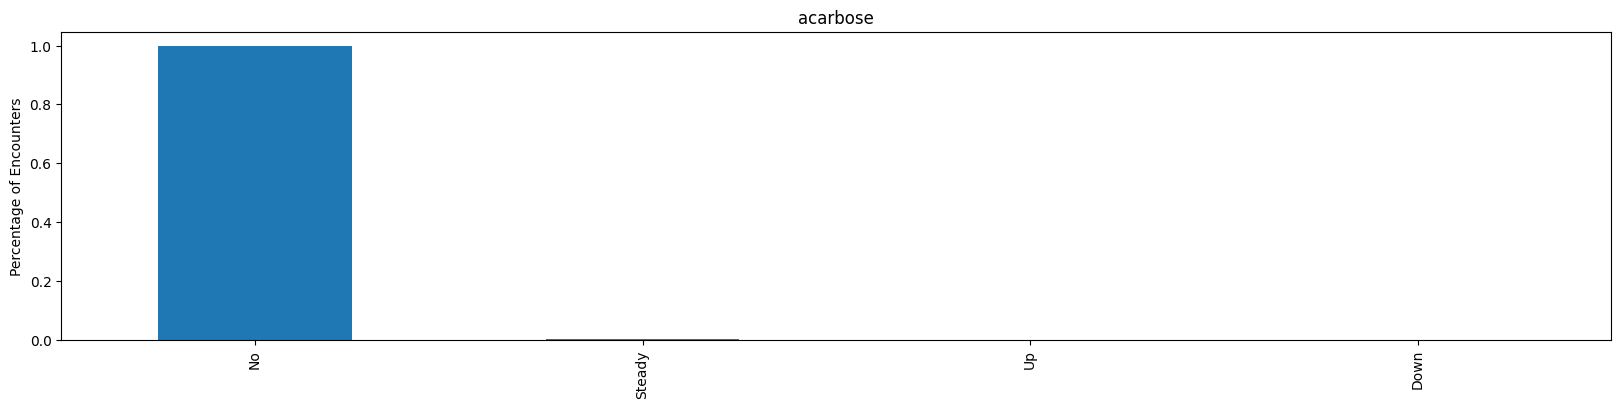

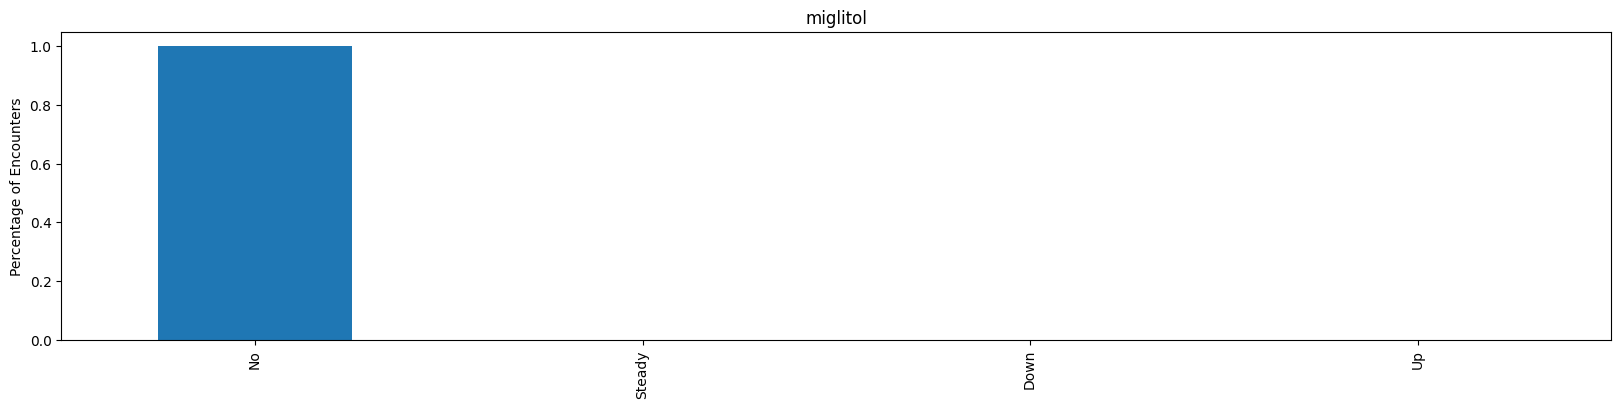

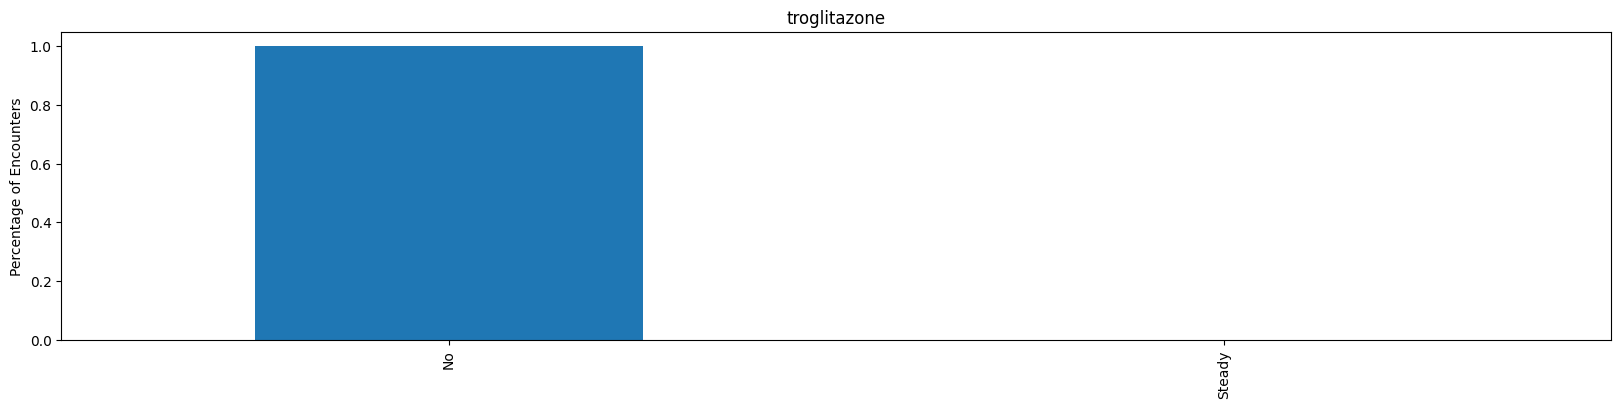

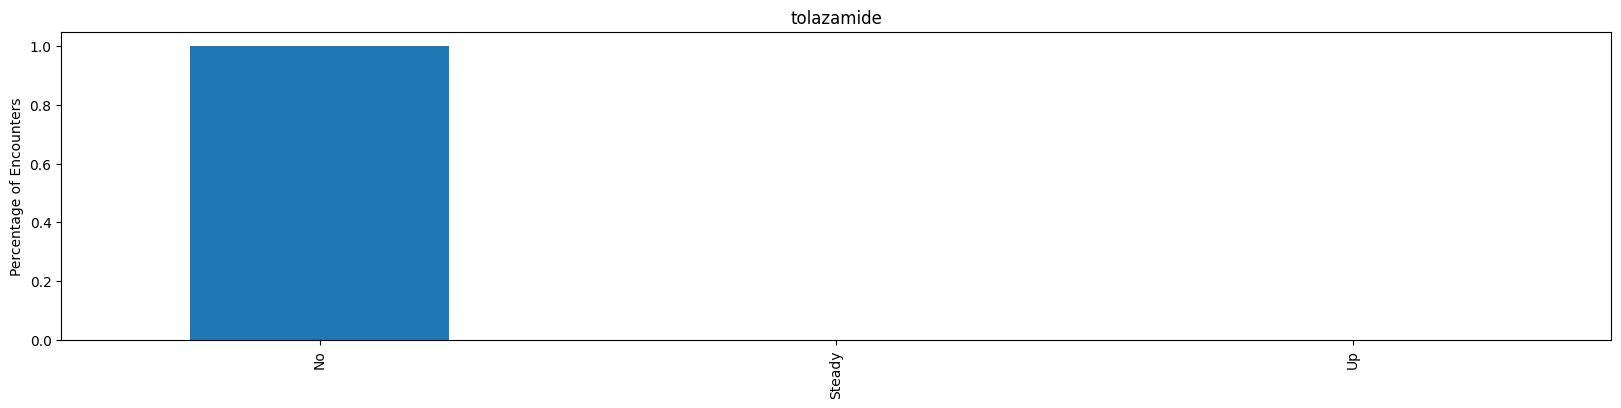

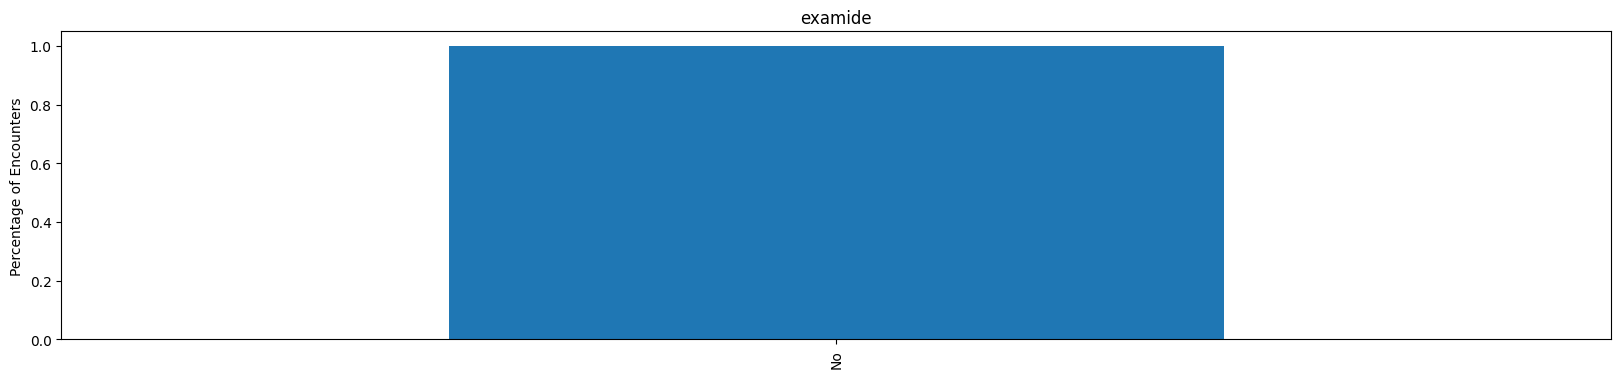

Dropping examide since constant value


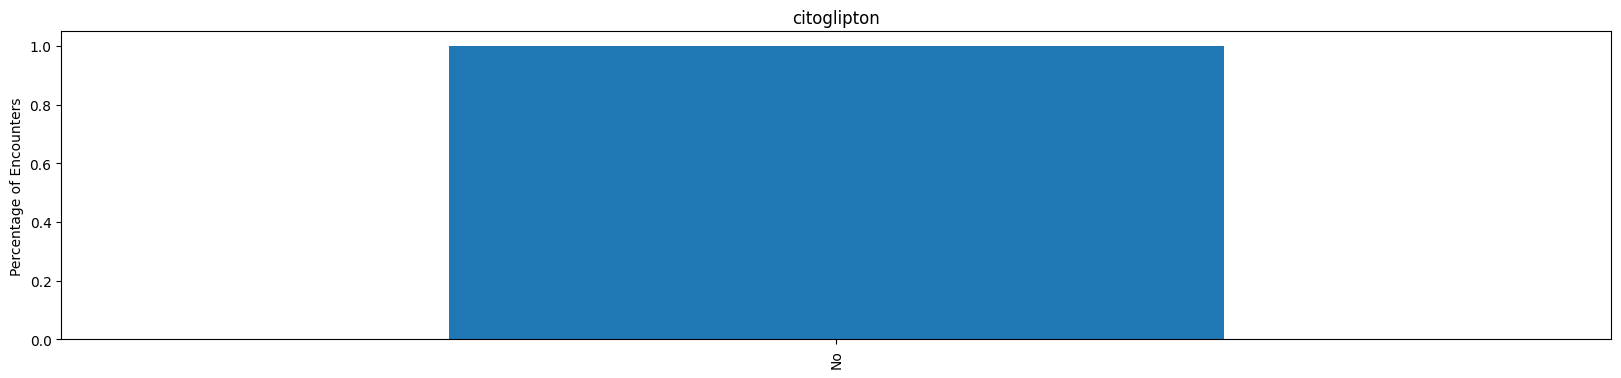

Dropping citoglipton since constant value


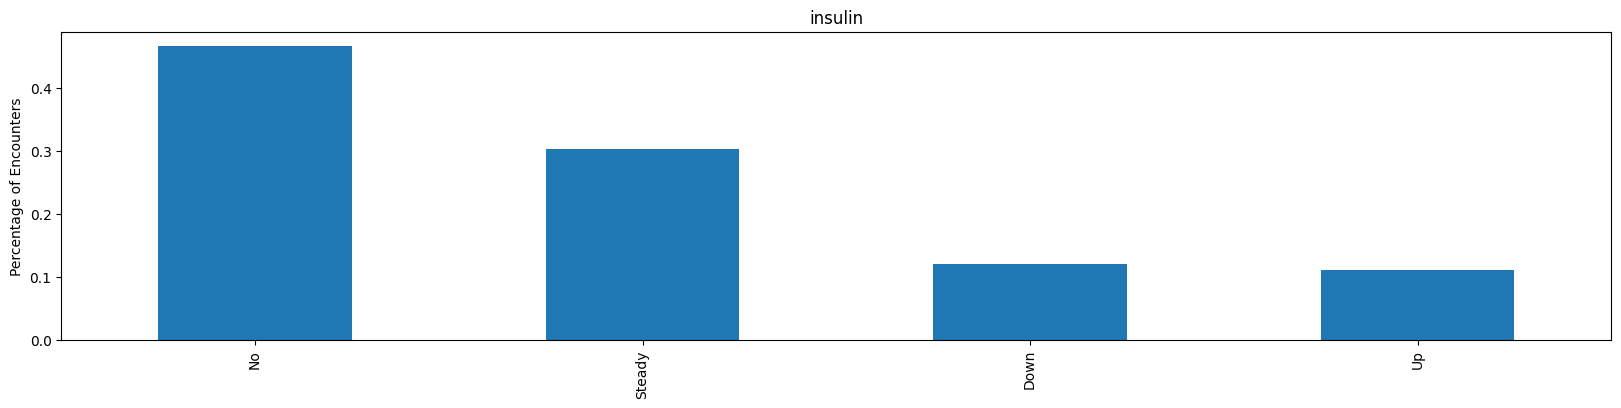

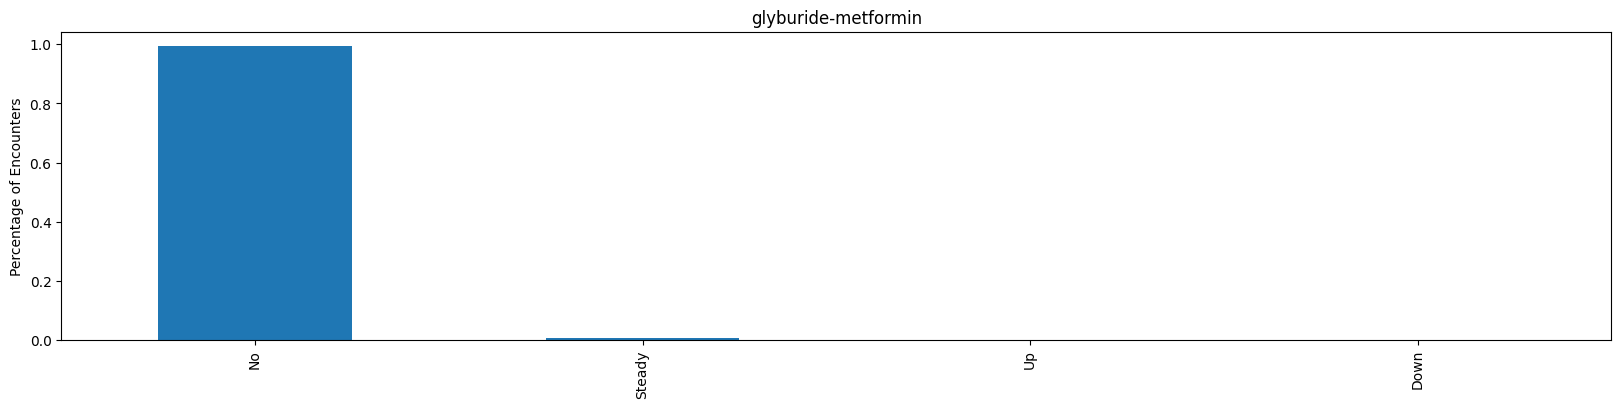

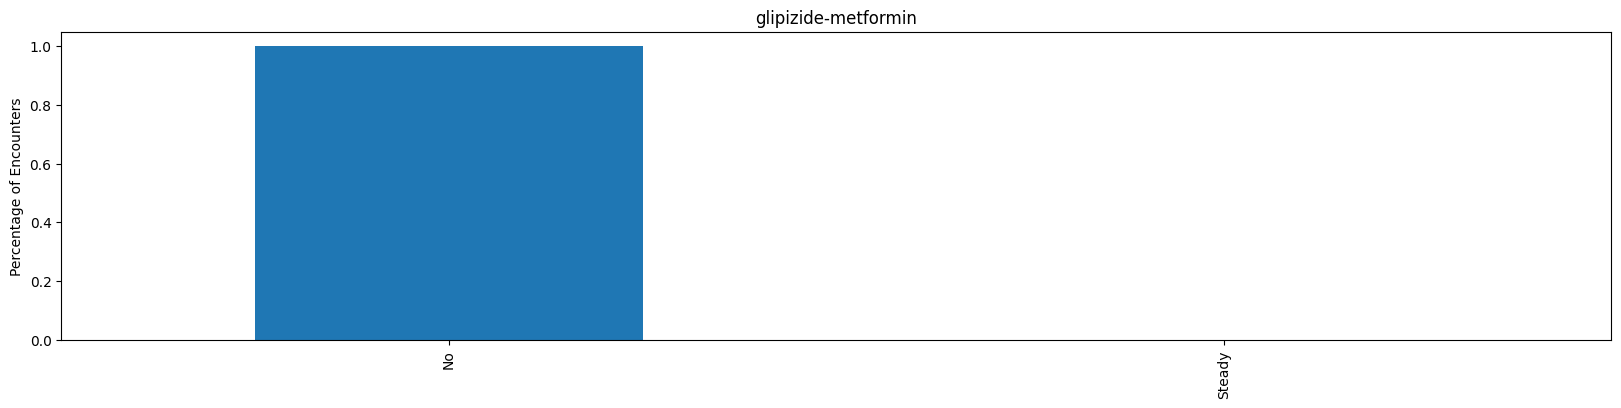

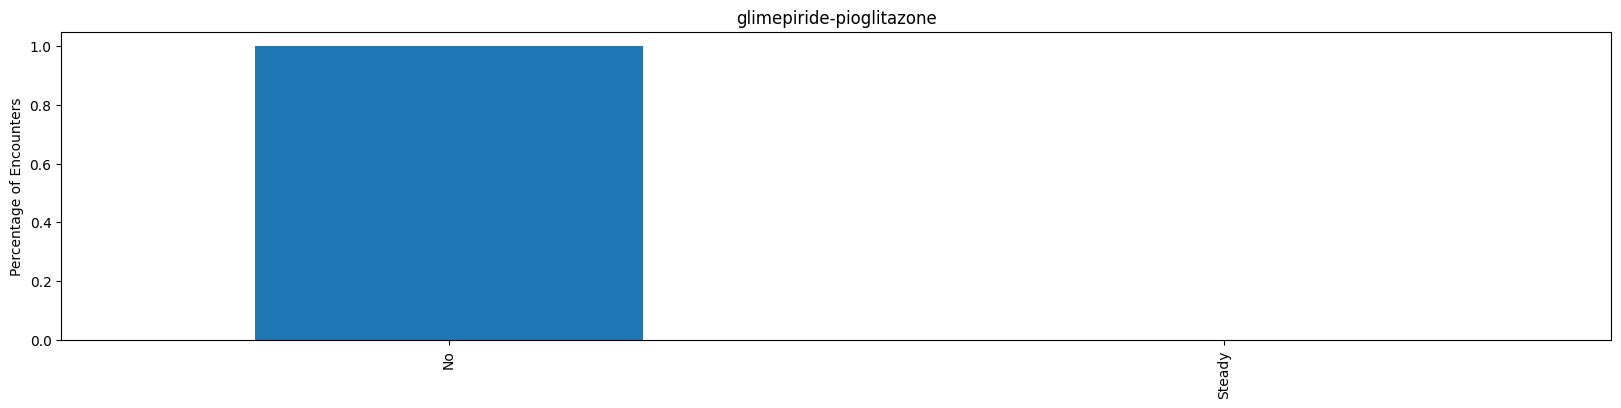

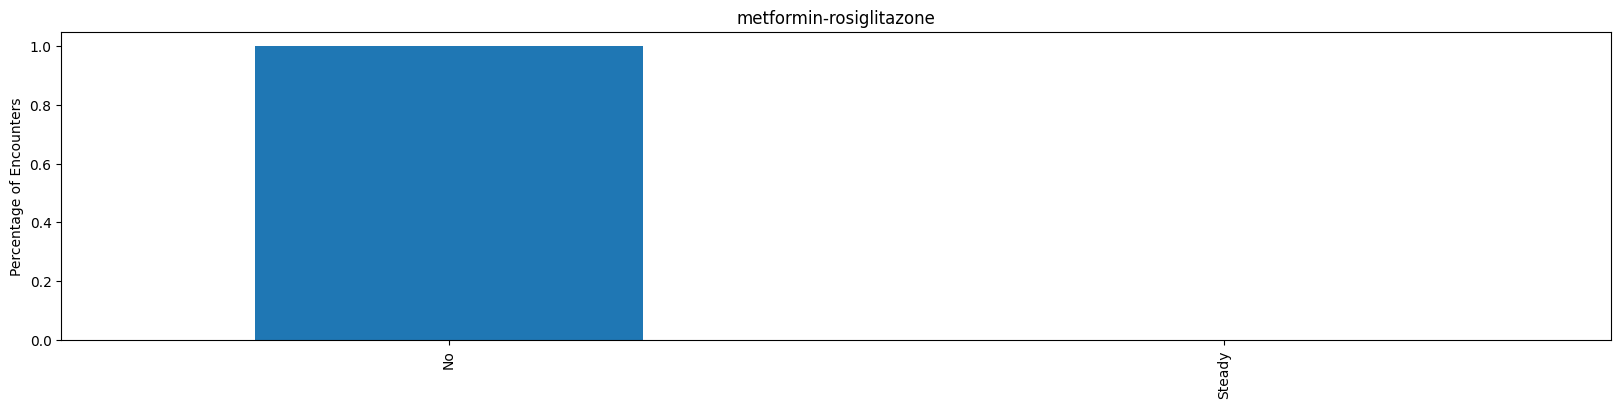

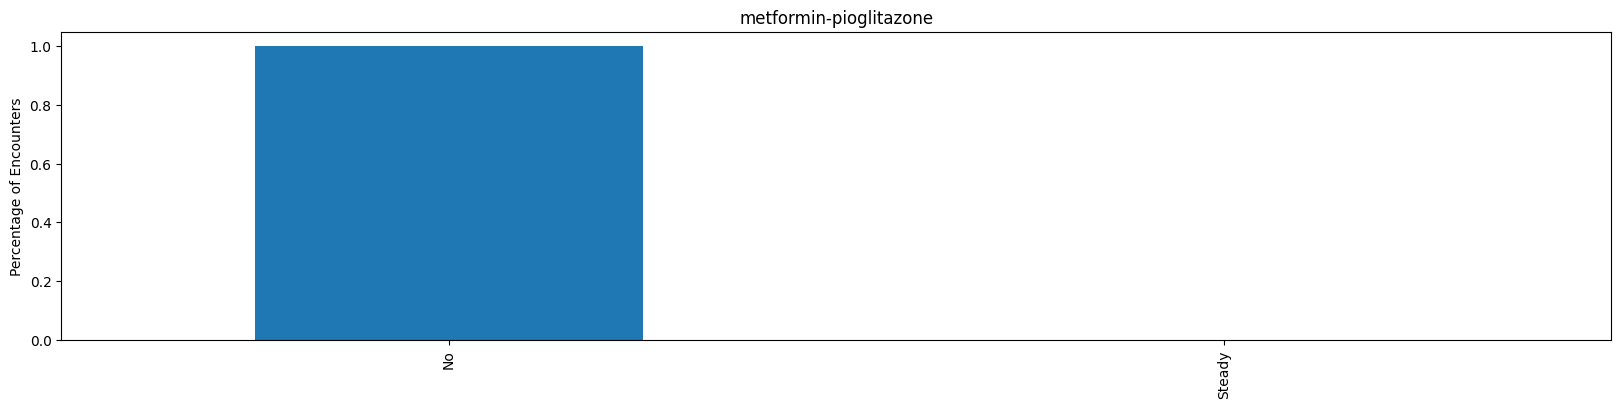

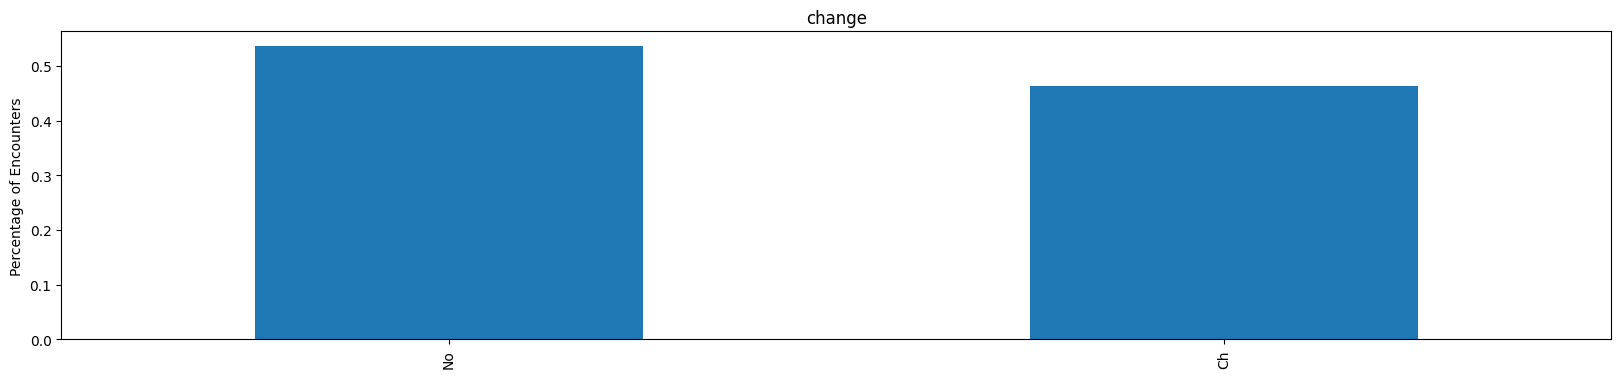

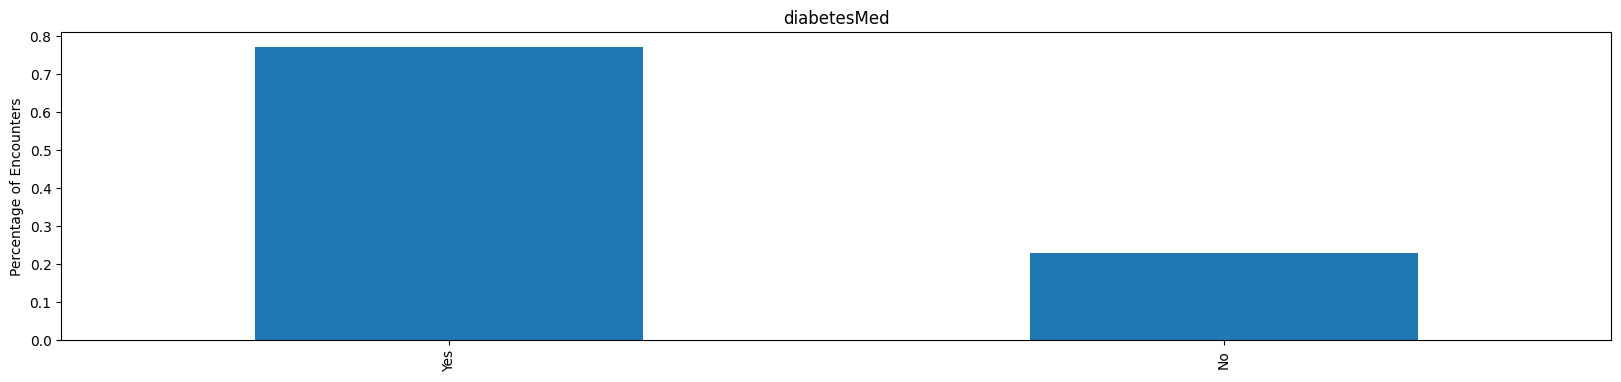

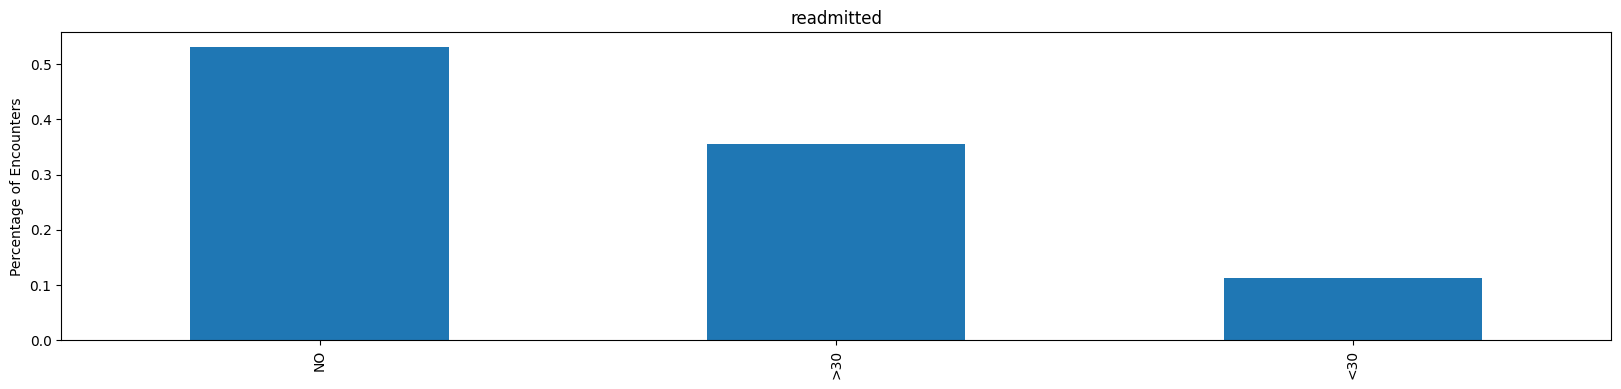

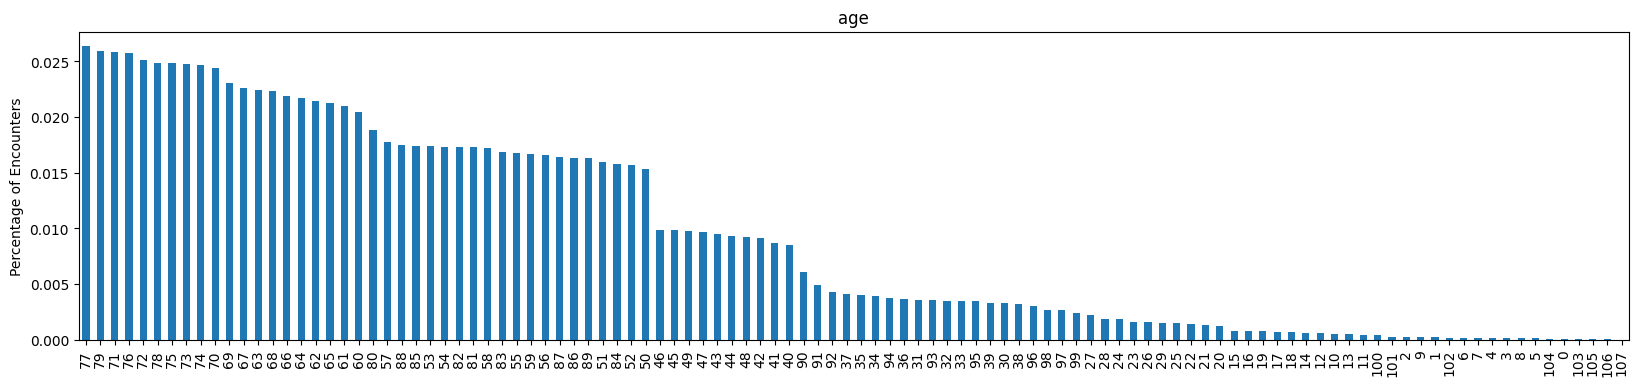

In [ ]:
# Visualize distribution of each feature and target. Drop constant feature if any.
for column in diabetes_df.columns:
    if "_date" in column:
        continue
    plt.figure(figsize=(20,4))
    column_value_counts = diabetes_df[column].value_counts(normalize=True)
    column_value_counts.plot(kind='bar')
    plt.ylabel('Percentage of Encounters')
    plt.title(column)
    plt.show()

    if column_value_counts.reset_index().shape[0]==1:
        diabetes_df = diabetes_df.drop(column, axis=1)
        print("Dropping %s since constant value" % column)

#### Further data processing, like removing features that are dominated by one value over others, and feature engineering methods, like converting categorical features to numerical (one-hot-encoding, label encoding) scaling for normalization (z-norm, min-max, etc.), are not performed since the <u>_**automated machine learning library used later on during training will automatically handle these data processing and feature engineering steps.**_</u>

### 1.8 Convert prediction outcome to binary
#### class 0 : 'NO' == 0, '>30' == 0
#### class 1 : '<30' == 1

#### After conversion, 11,357 encounters resulted in readmittance while 88,757 didn't. <u>_**11.34% of encounters resulted in readmittance.**_</u>
#### This is an imbalance dataset.

In [ ]:
# Convert target to binary. NO == 0, > 30 == 0, < 30 == 1 according to instructions.
print("Counts for each class of target before consolidating")
print(diabetes_df['readmitted'].value_counts())

diabetes_df['readmitted'] = diabetes_df['readmitted'].map({'NO': 0, '>30': 0, '<30': 1})
print("\nCounts for each class of target after consolidating")
print(diabetes_df['readmitted'].value_counts())

df_readmited = diabetes_df['readmitted'].value_counts(normalize=True).reset_index()
readmitted_percent = df_readmited[df_readmited['index']==1]['readmitted'].values[0]*100
print("\n%.2f%% of encounters resulted in readmittance in less than 30 days" % readmitted_percent)

Counts for each class of target before consolidating
NO     53212
>30    35545
<30    11357
Name: readmitted, dtype: int64

Counts for each class of target after consolidating
0    88757
1    11357
Name: readmitted, dtype: int64

11.34% of encounters resulted in readmittance in less than 30 days


### 1.9 Check correlation strength with readmittance
#### Low correlation between readmittance and other numerical features

In [ ]:
# Check for correlation strength with target
diabetes_df_numerics = diabetes_df.select_dtypes(include=np.number)
print(diabetes_df_numerics.corr()['readmitted'].sort_values())

num_procedures       -0.010485
number_outpatient     0.019097
num_lab_procedures    0.023385
age                   0.028689
num_medications       0.040725
time_in_hospital      0.045530
number_diagnoses      0.052343
number_emergency      0.060787
readmitted            1.000000
Name: readmitted, dtype: float64


#### Visualizing correlation heatmap between all the features shows a <u>_**higher correlation between 'time_in_hospital' and 'num_lab_procedures', 'num_procedures', 'num_medications'.**_</u>
#### The reason for longer time spent in hospital is probably connected to more labs, procedure and medications being prescribed and those takes time to get executed. 
#### This also indicates some colinearity between these features.

number_emergency     -0.009669
number_outpatient    -0.009469
readmitted            0.045530
age                   0.108489
num_procedures        0.190051
number_diagnoses      0.221034
num_lab_procedures    0.319754
num_medications       0.464082
time_in_hospital      1.000000
Name: time_in_hospital, dtype: float64


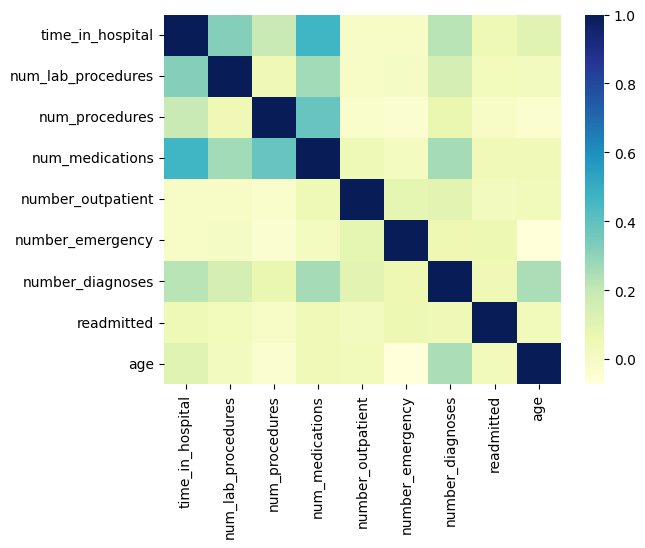

In [ ]:
# Check for correlation with all features
sns.heatmap(diabetes_df_numerics.corr(), cmap="YlGnBu");

# Check for correlation strength with 'time_in_hospital'
print(diabetes_df_numerics.corr()['time_in_hospital'].sort_values())

### 1.10 Last checks on data before training

In [ ]:
# Check data for training
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100114 entries, 0 to 101765
Data columns (total 44 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      97875 non-null   object
 1   gender                    100114 non-null  object
 2   admission_type_id         100114 non-null  object
 3   discharge_disposition_id  100114 non-null  object
 4   admission_source_id       100114 non-null  object
 5   time_in_hospital          100114 non-null  int64 
 6   payer_code                60523 non-null   object
 7   medical_specialty         50985 non-null   object
 8   num_lab_procedures        100114 non-null  int64 
 9   num_procedures            100114 non-null  int64 
 10  num_medications           100114 non-null  int64 
 11  number_outpatient         100114 non-null  int64 
 12  number_emergency          100114 non-null  int64 
 13  diag_1                    100093 non-null  object
 14  diag

## 2. Automatic machine learning training

### 2.1 Split data into training and test dataset
#### Set target for machine learning training to 'readmitted' and split 20% of data to test dataset while the other 80% to training dataset.

In [ ]:
# Split into test train. Note this dataset split contains target.
randomState = 666
target = 'readmitted'
(df_train, df_test) = train_test_split(diabetes_df, random_state=randomState, test_size=0.2, stratify=diabetes_df[target])

In [ ]:
# Quick fit Autogluon
# import autogluon.eda.auto as auto
# state = auto.quick_fit(
#     df_train, 
#     target, 
#     return_state=True,
#     show_feature_importance_barplots=True
# )

### 2.2 Resampling of training dataset into balanced subsets
#### Further split the training dataset into subsets that are more balanced for the 2 classes like cross-validation.
#### This avoids the need to decide on more appropriate metrics like F1, F1_micro or balanced accuracy for imbalance datasets and avoids need for imbalance approaches like SMOTE (synthetic minority oversampling technique) to oversample the minority class.
##### Footenote:
##### *F1 is harmonic mean of Precision and Recall and do not consider True Negatives (applicable for this readmittance scenario since predicting nothing will happen and nothing happened does not add to predictivity).
##### *F1_micro is the weight aggregation Precision and Recall of all class, so class imbalances are factored in.
##### *Balanced accuracy is the average of Recall and Specificity, but since True Negatives are not important in this scenario, Specificity not a critical metric.
##### *Confusion matrix definitions
<img src="confusionmatrix.png" width="700" height="300">

In [ ]:
# Calculate the ratio of unbalanced class and split data into parts such that each part is balanced with the minority class repeated.
print("%s \n" % df_train[target].value_counts())
unbalance_ratio = np.ceil(df_train[target].value_counts()[0]/df_train[target].value_counts()[1]).astype(int)
print("Ratio between the 2 classes: %d" % unbalance_ratio)

splits_list, df_train_readmitonly, df_train_noreadmitonly = helper.split_data_into_array_by_index(target, df_train, unbalance_ratio)
print("Training dataset split into %d subsets." % len(splits_list))

0    71005
1     9086
Name: readmitted, dtype: int64 

Ratio between the 2 classes: 8
Training dataset split into 8 subsets.


### 2.3 Automated machine learning training using AutoGluon
#### [Autogluon](https://auto.gluon.ai/stable/index.html) is an open source automated machine learning library developed by Amazon's AWS. 
#### It automatically detects the different datatypes in the dataset and applies the appropriate data processing and feature engineering methods.
#### It uses multiple different model types (XGBoost, LightGBM, CatBoost, RandomForest, kNN and Neural Networks), creating [multi-layer stacking to create ensemble model](https://arxiv.org/abs/2003.06505), and performs hyperparameter tuning. The ensemble model is generated by training at each layer through concatentating and adding weights, repeating for added layers.
<img src="autogluon_stacking.png" width="500" height="500">

#### Autogluon requires defining the level of model quality, model type and metric. 
#### Medium quality was selected to speed up computation by limiting the hyperparameter search space and number of models used.
#### For binary classifications, 'binary' was chosen.
#### 'roc_auc' metric was selected since its better to use probability as evaluator for this scenario.
##### Footnote:
##### *ROC_AUC is the area under the receiver operator curve (True Positive Rate vs False Positive Rate).
##### *True Positive Rate (TPR) = Recall
##### *False Positive Rate (FPR) = FP/(FP + TN)

In [ ]:
quality = 'medium_quality_faster_train'
type = 'binary'
metric = 'roc_auc'
run_training = False  # flag to run training or not

if run_training:
    for i, index_list in enumerate(splits_list):
        df_train_noreadmitonly_split = df_train_noreadmitonly[df_train_noreadmitonly.index.isin(index_list)]
        print(index_list)
        
        df_train_split = pd.concat([df_train_noreadmitonly_split, df_train_readmitonly], axis=0)
        print(i, df_train_split.shape)
        print(df_train_split[target].value_counts())
        
        save_path = str(unbalance_ratio) + '/split_' + str(i) + '_' + quality + '_' + metric
        print(save_path)
    
        helper.runAutoGluon(target, df_train_split, save_path, quality, type, metric)

In [ ]:
# Evaluate training
df_train_notarget = df_train.drop(columns=[target], axis=1)
train_y_pred_proba_list, train_y_pred_list, train_predictor_list = helper.ensemble_predictions_from_splits(quality, metric, df_train, target, unbalance_ratio, evaluate=True, verbose=False)
train_y_pred_proba_mean = helper.ensemble_proba(train_y_pred_proba_list)
train_y_pred_mean = helper.ensemble_pred(train_y_pred_list, target, unbalance_ratio)



8/split_0_medium_quality_faster_train_roc_auc
{'roc_auc': 0.81914220433488, 'accuracy': 0.6336042751370317, 'balanced_accuracy': 0.7245448901818291, 'mcc': 0.28664753732024284, 'f1': 0.3427624358888217, 'precision': 0.2151674493152996, 'recall': 0.8421747743781642}

Confusion Matrix normalized by all counts
[[0.53806295 0.34849109]
 [0.01790463 0.09554132]]


8/split_1_medium_quality_faster_train_roc_auc
{'roc_auc': 0.8665191124198547, 'accuracy': 0.6546178721704061, 'balanced_accuracy': 0.7627415574355931, 'mcc': 0.33600153136968103, 'f1': 0.37223129992737836, 'precision': 0.23446166161587284, 'recall': 0.9025974025974026}

Confusion Matrix normalized by all counts
[[0.55222185 0.3343322 ]
 [0.01104993 0.10239602]]


8/split_2_medium_quality_faster_train_roc_auc
{'roc_auc': 0.8244745268564312, 'accuracy': 0.6295963341698818, 'balanced_accuracy': 0.7261715106172826, 'mcc': 0.28835127772262514, 'f1': 0.34268368341753086, 'precision': 0.2145314320590357, 'recall': 0.851089588377724}

C

ROC_AUC: 0.870
F1: 0.420
F1 micro: 0.748
F1 macro: 0.630

Confusion Matrix normalized by Truth
[[0.74106049 0.25893951]
 [0.19524543 0.80475457]]


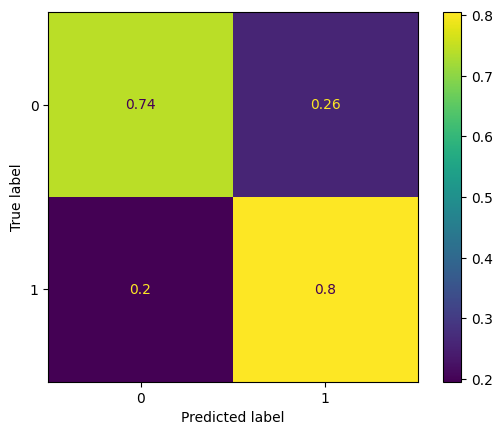

In [ ]:
# Evaluate metrics and confusion matrix normalized by truth
helper.calculate_scores_normalized_truth(df_train, target, train_y_pred_proba_mean, train_y_pred_mean)

ROC_AUC: 0.870
F1: 0.420
F1 micro: 0.748
F1 macro: 0.630

Confusion Matrix normalized by total count
[[0.65699017 0.22956387]
 [0.0221498  0.09129615]]


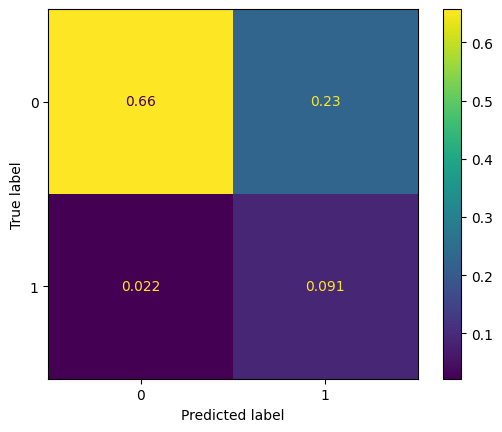

In [ ]:
# Evaluate metrics and confusion matrix normalized by all
helper.calculate_scores_normalized_all(df_train, target, train_y_pred_proba_mean, train_y_pred_mean)

### 2.4 Evaluate the Autogluon model for each of the data subsets
#### Load each of the Autogluon model.
#### Make predictions in both binary and probability form using the test dataset.
#### Aggregate probabilities and binary outputs by averaging to form an ensemble model.

In [ ]:
# Evaluate test
df_test_notarget = df_test.drop(columns=[target], axis=1)
test_y_pred_proba_list, test_y_pred_list, test_predictor_list = helper.ensemble_predictions_from_splits(quality, metric, df_test, target, unbalance_ratio, evaluate=True, verbose=True)
test_y_pred_proba_mean = helper.ensemble_proba(test_y_pred_proba_list)
test_y_pred_mean = helper.ensemble_pred(test_y_pred_list, target, unbalance_ratio)



8/split_0_medium_quality_faster_train_roc_auc


These features in provided data are not utilized by the predictor and will be ignored: ['acetohexamide', 'tolazamide', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-pioglitazone']


                  model  score_test  score_val  pred_time_test  pred_time_val  \
0              CatBoost    0.659559   0.650714        0.123998       0.031224   
1   WeightedEnsemble_L2    0.659087   0.654537        3.048357       0.461790   
2            LightGBMXT    0.648803   0.644217        0.145140       0.031664   
3         LightGBMLarge    0.637118   0.633154        0.103788       0.015633   
4      RandomForestEntr    0.633611   0.622937        1.829222       0.169339   
5      RandomForestGini    0.633195   0.621812        1.945999       0.157134   
6        NeuralNetTorch    0.631734   0.639624        0.441995       0.078142   
7              LightGBM    0.629672   0.626057        0.129179       0.015633   
8       NeuralNetFastAI    0.625623   0.624043        0.928606       0.103703   
9        ExtraTreesEntr    0.625420   0.614247        2.585875       0.187942   
10       ExtraTreesGini    0.623201   0.619198        1.034836       0.169250   
11       KNeighborsUnif    0

These features in provided data are not utilized by the predictor and will be ignored: ['acetohexamide', 'tolbutamide', 'troglitazone', 'tolazamide', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']


                  model  score_test  score_val  pred_time_test  pred_time_val  \
0              CatBoost    0.660076   0.667315        0.201838       0.041822   
1   WeightedEnsemble_L2    0.657979   0.675609        1.951407       0.369149   
2            LightGBMXT    0.644629   0.669153        0.187969       0.031676   
3      RandomForestEntr    0.634053   0.644598        0.815434       0.156685   
4        NeuralNetTorch    0.633690   0.643917        0.569169       0.076043   
5      RandomForestGini    0.632168   0.633238        2.124741       0.172834   
6         LightGBMLarge    0.631253   0.651950        0.163995       0.062923   
7       NeuralNetFastAI    0.629398   0.633115        0.967247       0.104285   
8              LightGBM    0.625491   0.644885        0.167189       0.031251   
9        ExtraTreesEntr    0.623578   0.621711        2.589121       0.172828   
10       ExtraTreesGini    0.619883   0.620479        2.627630       0.157104   
11       KNeighborsDist    0

These features in provided data are not utilized by the predictor and will be ignored: ['acetohexamide', 'tolbutamide', 'troglitazone', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']


                  model  score_test  score_val  pred_time_test  pred_time_val  \
0   WeightedEnsemble_L2    0.658000   0.671884        4.532835       0.816143   
1              CatBoost    0.656461   0.668264        0.259302       0.046879   
2            LightGBMXT    0.651055   0.659025        0.113966       0.031276   
3         LightGBMLarge    0.636424   0.637322        0.216000       0.031272   
4      RandomForestEntr    0.633248   0.642615        0.765667       0.204067   
5      RandomForestGini    0.632587   0.640906        0.784178       0.169689   
6              LightGBM    0.632098   0.636443        0.139103       0.046902   
7        NeuralNetTorch    0.627912   0.644647        0.417001       0.062532   
8       NeuralNetFastAI    0.626041   0.637539        0.882998       0.085626   
9        ExtraTreesGini    0.625550   0.636197        1.006686       0.161188   
10       ExtraTreesEntr    0.624854   0.630338        2.629673       0.173329   
11       KNeighborsDist    0

These features in provided data are not utilized by the predictor and will be ignored: ['acetohexamide', 'troglitazone', 'tolazamide', 'glimepiride-pioglitazone', 'metformin-pioglitazone']


                  model  score_test  score_val  pred_time_test  pred_time_val  \
0              CatBoost    0.656237   0.666519        0.312251       0.041940   
1   WeightedEnsemble_L2    0.652788   0.673464        2.947545       0.443181   
2            LightGBMXT    0.642268   0.667451        0.162771       0.047259   
3        NeuralNetTorch    0.632413   0.638683        0.695002       0.069551   
4         LightGBMLarge    0.630092   0.657250        0.283002       0.020618   
5      RandomForestEntr    0.628389   0.639283        0.851435       0.162054   
6      RandomForestGini    0.627887   0.636126        2.232478       0.171751   
7       NeuralNetFastAI    0.626818   0.637587        1.087320       0.109829   
8              LightGBM    0.625128   0.655233        0.128095       0.016619   
9        ExtraTreesGini    0.622632   0.619049        2.897883       0.157105   
10       ExtraTreesEntr    0.620290   0.620215        2.618716       0.208198   
11       KNeighborsUnif    0

These features in provided data are not utilized by the predictor and will be ignored: ['acetohexamide', 'troglitazone', 'tolazamide', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']


                  model  score_test  score_val  pred_time_test  pred_time_val  \
0   WeightedEnsemble_L2    0.661292   0.650804        5.205025       0.578591   
1              CatBoost    0.660331   0.648076        0.323158       0.039086   
2            LightGBMXT    0.645944   0.642980        0.246420       0.040694   
3       NeuralNetFastAI    0.638811   0.631078        1.148784       0.108040   
4      RandomForestEntr    0.636228   0.623765        1.951786       0.170053   
5      RandomForestGini    0.634657   0.622577        1.319876       0.187465   
6         LightGBMLarge    0.632729   0.632690        0.196999       0.033253   
7              LightGBM    0.627165   0.627452        0.112999       0.031279   
8        NeuralNetTorch    0.625191   0.618570        0.492999       0.078537   
9        ExtraTreesGini    0.620966   0.607388        2.861494       0.163402   
10       ExtraTreesEntr    0.620312   0.602393        2.799647       0.184731   
11       KNeighborsUnif    0

These features in provided data are not utilized by the predictor and will be ignored: ['acetohexamide', 'troglitazone', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']


                  model  score_test  score_val  pred_time_test  pred_time_val  \
0   WeightedEnsemble_L2    0.654846   0.649359        3.520107       0.279311   
1              CatBoost    0.654347   0.647381        0.214039       0.031268   
2            LightGBMXT    0.641629   0.642330        0.183522       0.015624   
3      RandomForestGini    0.632279   0.620166        1.929431       0.157102   
4      RandomForestEntr    0.631906   0.618731        1.899305       0.181439   
5         LightGBMLarge    0.630191   0.632130        0.192453       0.032965   
6              LightGBM    0.627885   0.624776        0.132505       0.031689   
7        NeuralNetTorch    0.621120   0.619293        0.480246       0.064314   
8        ExtraTreesEntr    0.620385   0.617885        2.617296       0.168104   
9        ExtraTreesGini    0.617419   0.611680        2.568691       0.171846   
10      NeuralNetFastAI    0.613639   0.606817        0.930402       0.094175   
11       KNeighborsDist    0

These features in provided data are not utilized by the predictor and will be ignored: ['acetohexamide', 'tolbutamide', 'troglitazone', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']


                  model  score_test  score_val  pred_time_test  pred_time_val  \
0              CatBoost    0.658022   0.642318        0.285996       0.046879   
1   WeightedEnsemble_L2    0.652360   0.659079       10.177626       0.936864   
2            LightGBMXT    0.643430   0.652575        0.226154       0.043745   
3      RandomForestEntr    0.635509   0.633543        1.876553       0.173995   
4         LightGBMLarge    0.631943   0.627104        0.207999       0.031266   
5      RandomForestGini    0.630366   0.627224        1.930997       0.173677   
6        NeuralNetTorch    0.626990   0.628399        0.482003       0.085023   
7              LightGBM    0.625039   0.623152        0.151998       0.046878   
8        ExtraTreesGini    0.624211   0.623100        2.566344       0.161965   
9        ExtraTreesEntr    0.623391   0.621909        2.488368       0.202338   
10      NeuralNetFastAI    0.620174   0.614623        0.947801       0.113322   
11       KNeighborsDist    0

These features in provided data are not utilized by the predictor and will be ignored: ['tolbutamide', 'troglitazone', 'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone', 'metformin-pioglitazone']


                  model  score_test  score_val  pred_time_test  pred_time_val  \
0              CatBoost    0.657944   0.661579        0.313318       0.048866   
1   WeightedEnsemble_L2    0.656940   0.673861        5.790801       0.557802   
2            LightGBMXT    0.648818   0.659174        0.203967       0.046897   
3         LightGBMLarge    0.633779   0.651072        0.298194       0.031281   
4      RandomForestEntr    0.631461   0.648196        1.885580       0.173227   
5      RandomForestGini    0.629570   0.651095        1.921793       0.191519   
6        NeuralNetTorch    0.627798   0.626791        0.526509       0.057513   
7              LightGBM    0.626441   0.643274        0.140336       0.025652   
8       NeuralNetFastAI    0.626327   0.628544        0.946604       0.125455   
9        ExtraTreesEntr    0.624747   0.632908        2.594780       0.189693   
10       ExtraTreesGini    0.623958   0.638670        2.613675       0.168034   
11       KNeighborsDist    0

ROC_AUC: 0.664
F1: 0.275
F1 micro: 0.679
F1 macro: 0.535

Confusion Matrix normalized by Truth
[[0.69749887 0.30250113]
 [0.46279172 0.53720828]]


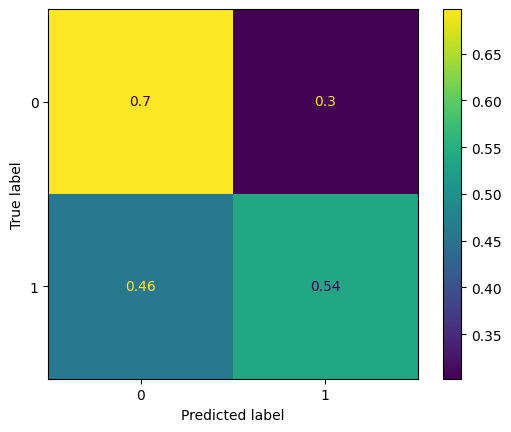

In [ ]:
# Evaluate metrics and confusion matrix normalized by truth
helper.calculate_scores_normalized_truth(df_test, target, test_y_pred_proba_mean, test_y_pred_mean)

#### 2.4.1 Calculate metrics and confusion matrix normalized by total count to see the performance.
#### From the confusion matrix, the False Negative is 5.2%, which is the rate where readmittance occured while none is predicted. This is the same indicator as the 11.34% encounters resulted in readmittance from the initial dataset. <u>_**The ensemble model is able to reduce the real-world readmittance rate by half.**_</u>
#### However, the False Positive is higher at 27%. Of all encounters, 27% that undergo additional discharge plan following the recommendation of ensemble model are unnecessary. This may lead to wasted resources. <u>_**Requires further analysis to determine whether savings in halving the costs of penalities may be greater or lesser than the added costs in 27% addition discharge plans.**_</u>

ROC_AUC: 0.664
F1: 0.275
F1 micro: 0.679
F1 macro: 0.535

Confusion Matrix normalized by total count
[[0.61838885 0.26819158]
 [0.05248964 0.06092993]]


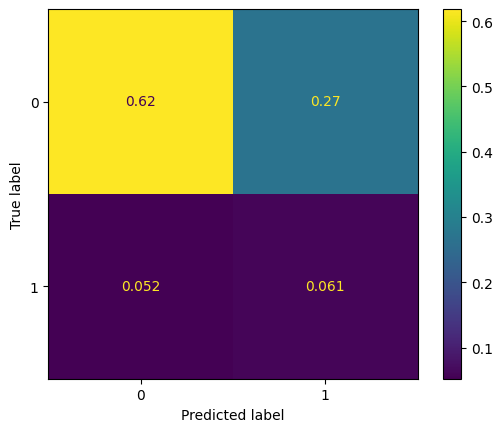

In [ ]:
# Evaluate metrics and confusion matrix normalized by all
helper.calculate_scores_normalized_all(df_test, target, test_y_pred_proba_mean, test_y_pred_mean)

## 2.5 Explain findings and insights from machine learning models

#### 2.5.1 Relative importance of all features according to SHAP
#### Load the Autogluon generate ensemble model and pass the prediction probabilities from the test dataset into SHAP.
#### Top features of importance are 'diag_1', 'discharge_disposition_id', 'diag_3', 'diag_2', 'num_medications', 'number_emergency'.
#### These indicate that the diagnosises and comorbidities and their related medications as well as reasons for initial discharge are main reasons for readmittance.
##### Footnote:
##### *SHAP value is the importance value assign to the feature, a measure of the degree of contribution and can be positive or negative.

In [ ]:
ag_wrapper = helper.AutogluonWrapper(test_predictor_list[0], df_train.columns)
df_train_mode = df_train.mode().iloc[0]
explainer = shap.KernelExplainer(ag_wrapper.predict_binary_prob, df_train_mode)

  0%|          | 0/100 [00:00<?, ?it/s]

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


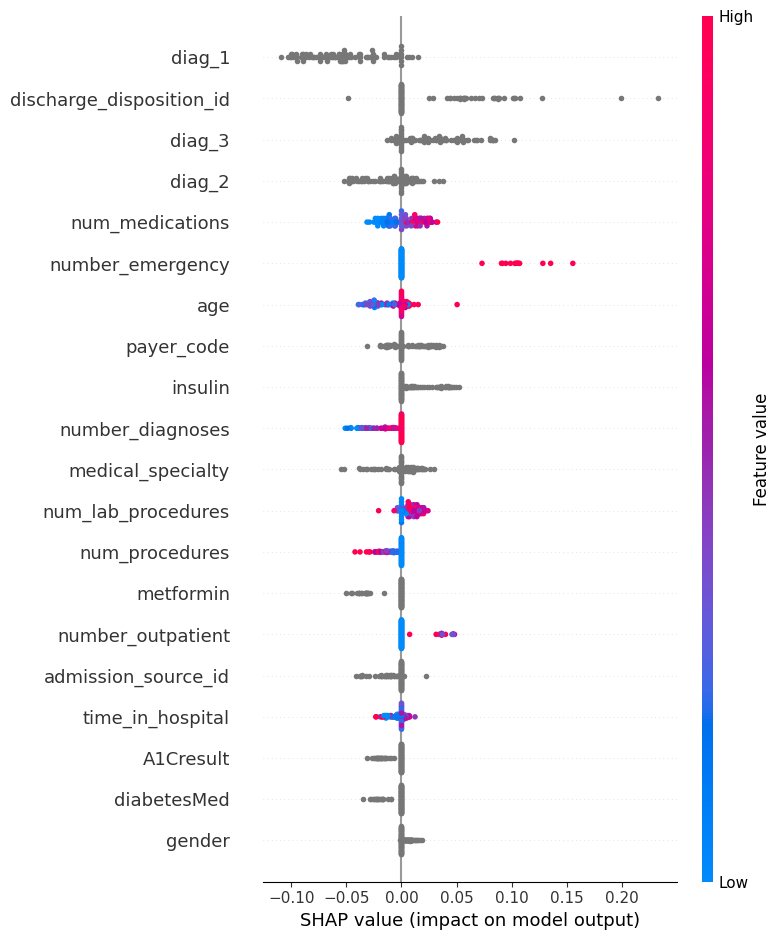

In [ ]:
N_VAL = 100
shap_values = explainer.shap_values(df_test.iloc[0:N_VAL,:], nsamples=100)
# shap.force_plot(explainer.expected_value, shap_values, df_test.iloc[0:N_VAL,:], matplotlib=True)
shap.summary_plot(shap_values, df_test.iloc[0:N_VAL,:])

#### Looking at 'discharge_disposition_id', the highest positive contribution to readmittance is 'Discharged/transferred to another rehab' (id=22).
#### 'Discharged/Transferred to SNF' (id=3), 'Discharged/transferred to home with home health service' (id=6), 'NULL' (id=18) also positively contribute to readmittance but to a lesser degree.
#### <u>_**Patients transferred to SNF and home with heath service, and especially transferred to another rehab should get more attention from discharge plans.**_</u>
#### Also make sure to record reason for discharge, too many NULLs.

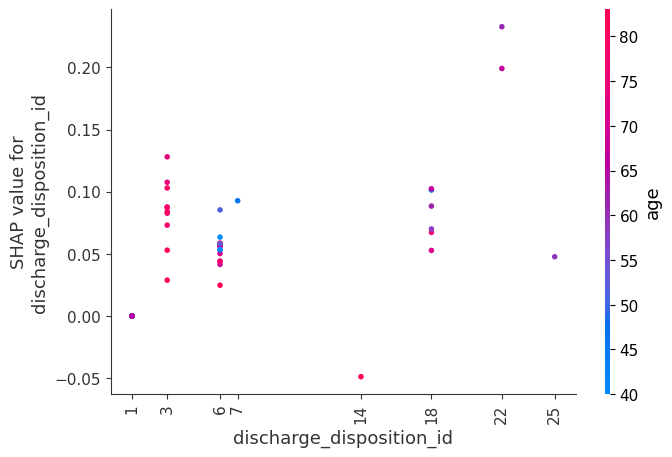

In [ ]:
shap.dependence_plot("discharge_disposition_id", shap_values, df_test.iloc[0:N_VAL,:], interaction_index="age")

#### Looking at 'number_emergency', patients with 1 and 2 emergencies seem to have higher positive contribution to readmittance. These patients may have a tendency to delay care until it becomes untolerable, requiring emergency care.
#### Compare this with 'number_outpatient' in the subsequent figure where the level of positive contribution to readmittance is about 3 to 4 times less. These outpatients may have tendency to take more preventative care and thus may end up with lower positive contribution to readmittance.
#### <u>_**Patients with outpatient care may have 3 to 4 times less positive contributing risk of readmittance.**_</u>

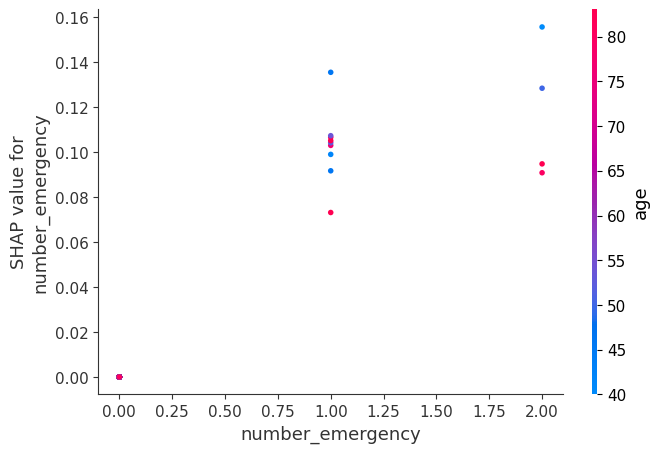

In [ ]:
shap.dependence_plot("number_emergency", shap_values, df_test.iloc[0:N_VAL,:], interaction_index="age")

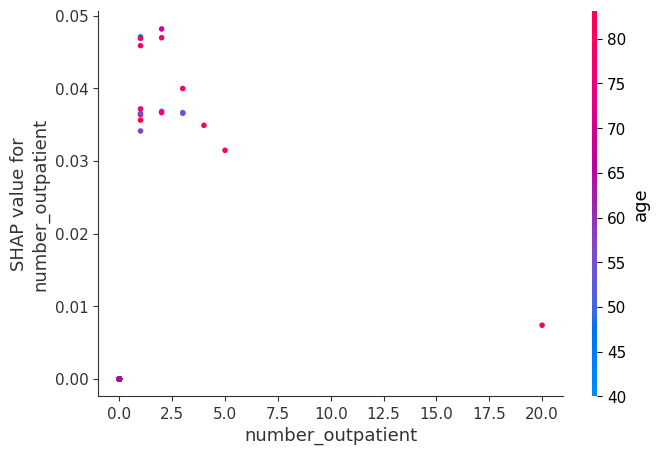

In [ ]:
shap.dependence_plot("number_outpatient", shap_values, df_test.iloc[0:N_VAL,:], interaction_index="age")

#### Looking at 'num_medications', there's a trend for higher contribution to readmittance with increasing number of medications. The trend crosses into positive contribution when the number of medications is greater than 15. This is expected since <u>_**more medication indicates more risk for complications, things to go wrong and hence readmittance.**_</u>

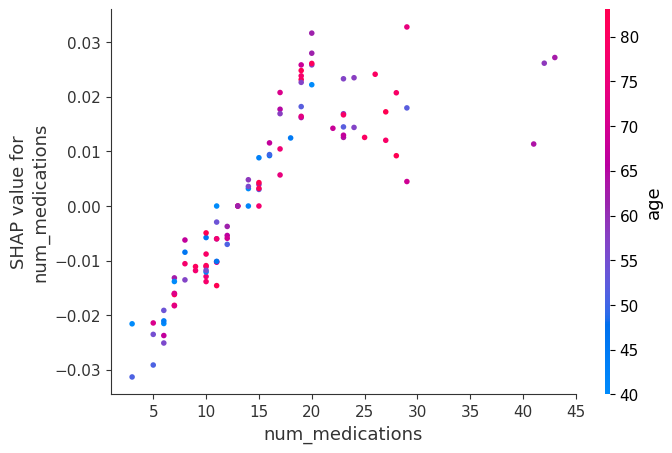

In [ ]:
shap.dependence_plot("num_medications", shap_values, df_test.iloc[0:N_VAL,:], interaction_index="age")

#### Looking at 'insulin', patients with 'Down' and 'Up' have about 3 to 4 times the positive contribution to readmittance than those with 'Steady'. This indicates <u>_**discharging patients while their insulin dosages are still fluctuating during the fine tuning process to find the proper dosage is a positive contributing factor to readmittance. Hospitals may need to have the patients' insulin dosage stablizied before discharge to reduce the positive contributing factor by 3 to 4 times.**_</u>

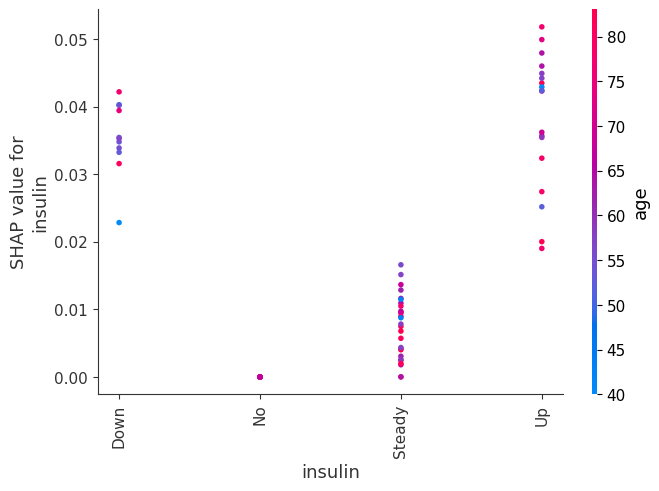

In [ ]:
shap.dependence_plot("insulin", shap_values, df_test.iloc[0:N_VAL,:], interaction_index="age")

#### Looking at 'num_procedures', there's a trend towards a negative contributing factor towards readmittance with increasing number of procedures. This is expected as <u>_**with more procedures, there's more attention and care to patient prior to discharge, hence lowering risk of readmittance.**_</u>

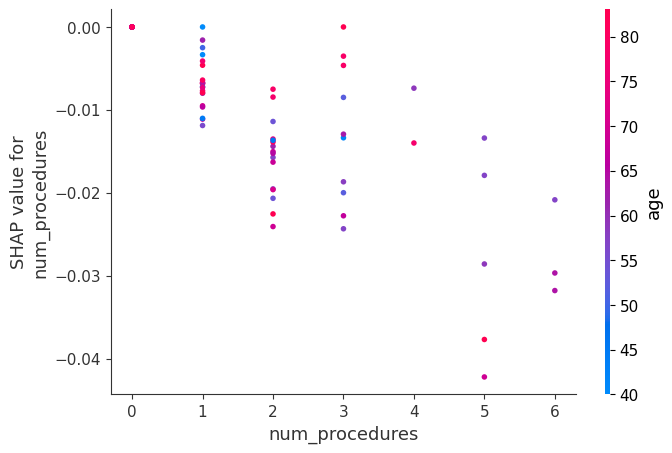

In [ ]:
shap.dependence_plot("num_procedures", shap_values, df_test.iloc[0:N_VAL,:], interaction_index="age")

#### Looking at 'gender', there's a <u>_**higher prevalence for male than female patients for readmittance**_</u> despite a relatively equal number of males and females in the initial dataset.

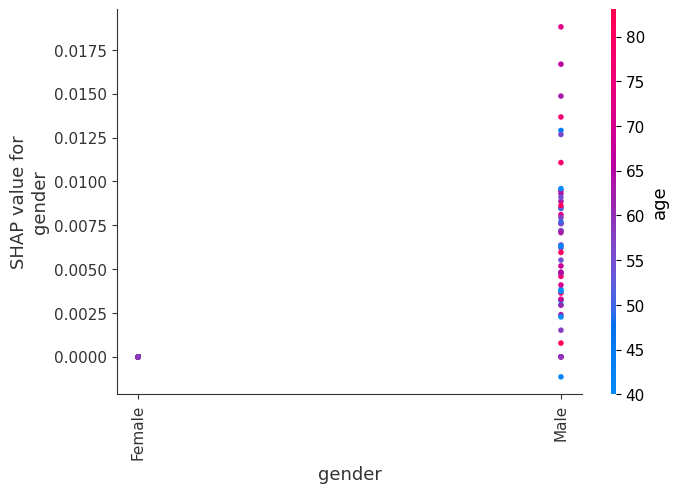

In [ ]:
shap.dependence_plot("gender", shap_values, df_test.iloc[0:N_VAL,:], interaction_index="age")

#### Looking at 'age', <u>_**patients younger than 60 years may have a more negative contributing factor towards readmittance than 70 years or older patients**_</u>, but this does not mean older patients have a greater positive contributing factor.

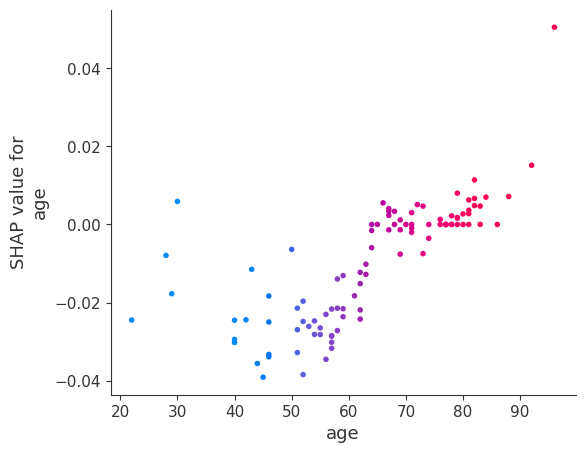

In [ ]:
shap.dependence_plot("age", shap_values, df_test.iloc[0:N_VAL,:], interaction_index="age")

#### 2.5.2 Test each enounter from the test dataset to see what contributed to the prediction probability.
#### Based on the probabilities of readmittance predicted on the test dataset using the ensemble model, the differences in probabilities for the 2 class are ranked to highlight the confidence of the predictions.

#### This first set is for the top 10 encounters with most confident prediction for positive readmittance.

In [ ]:
df_test_proba = pd.merge(df_test, test_y_pred_proba_mean, left_index=True, right_index=True)
df_test_proba['absolute error'] = (df_test_proba[1]-df_test_proba[0]).abs()
df_test_proba[(df_test_proba[1]>df_test_proba[0])].sort_values(by=['absolute error'], ascending=False)[:10]

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,age,0,1,absolute error
30399,Caucasian,Female,5,1,17,5,HM,NaN,17,1,...,No,No,No,Ch,Yes,0,34,0.164710,0.835290,0.670580
79467,Caucasian,Female,2,1,7,1,OG,Family/GeneralPractice,11,0,...,No,No,No,Ch,Yes,0,28,0.171808,0.828192,0.656383
62759,Caucasian,Female,1,1,7,3,OG,Emergency/Trauma,36,0,...,No,No,No,Ch,Yes,1,27,0.173566,0.826434,0.652867
24895,Caucasian,Female,5,1,17,6,HM,Nephrology,24,1,...,No,No,No,Ch,Yes,1,34,0.175835,0.824165,0.648330
94619,AfricanAmerican,Female,1,1,7,4,MC,NaN,13,0,...,No,No,No,No,Yes,0,58,0.176648,0.823352,0.646705
54510,Caucasian,Male,2,1,1,6,NaN,Oncology,49,1,...,No,No,No,No,Yes,0,48,0.178855,0.821145,0.642290
72063,Caucasian,Male,1,22,7,4,MC,NaN,39,0,...,No,No,No,Ch,Yes,0,79,0.183439,0.816561,0.633122
99483,Caucasian,Female,1,2,7,3,MD,Emergency/Trauma,73,1,...,No,No,No,Ch,Yes,0,43,0.186366,0.813634,0.627269
66439,AfricanAmerican,Male,1,1,7,2,MC,Nephrology,49,1,...,No,No,No,Ch,Yes,1,57,0.186433,0.813567,0.627133
93064,Caucasian,Male,2,1,7,6,MD,Emergency/Trauma,55,0,...,No,No,No,Ch,Yes,0,47,0.187099,0.812901,0.625802


#### This second set is for the top 10 encounters with most confident prediction for negative readmittance.

In [ ]:
df_test_proba[(df_test_proba[1]<df_test_proba[0])].sort_values(by=['absolute error'], ascending=False)[:10]

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,age,0,1,absolute error
3766,Caucasian,Female,1,1,7,2,NaN,Pediatrics-Endocrinology,46,0,...,No,No,No,No,Yes,0,1,0.866220,0.133780,0.732440
17561,Caucasian,Male,1,1,7,3,NaN,Pediatrics-Endocrinology,50,0,...,No,No,No,No,Yes,0,11,0.865774,0.134226,0.731549
18783,AfricanAmerican,Male,1,1,7,2,NaN,Pediatrics-Endocrinology,46,0,...,No,No,No,No,Yes,0,1,0.864163,0.135837,0.728326
57376,Asian,Female,3,1,1,2,MD,ObstetricsandGynecology,20,2,...,No,No,No,No,No,0,24,0.854003,0.145997,0.708006
17065,Caucasian,Female,1,1,4,2,NaN,Pediatrics-Endocrinology,57,0,...,No,No,No,No,Yes,0,8,0.848714,0.151286,0.697428
70456,Caucasian,Female,3,1,1,2,BC,ObstetricsandGynecology,11,2,...,No,No,No,No,No,0,36,0.843976,0.156024,0.687952
1675,AfricanAmerican,Female,1,1,7,3,NaN,Pediatrics-Endocrinology,51,0,...,No,No,No,No,Yes,0,11,0.840936,0.159064,0.681871
2355,Hispanic,Female,3,1,1,2,NaN,ObstetricsandGynecology,22,3,...,No,No,No,No,No,0,35,0.832052,0.167948,0.664104
19012,Caucasian,Male,1,1,7,4,NaN,Pediatrics-Endocrinology,47,0,...,No,No,No,No,Yes,0,7,0.832017,0.167983,0.664034
4571,Caucasian,Male,2,1,1,3,NaN,Pediatrics-Endocrinology,12,0,...,No,No,No,No,Yes,0,9,0.831604,0.168396,0.663208


#### This last set is for the top 10 encounters with least confident prediction for positive or negative readmittance.

In [ ]:
df_test_proba.sort_values(by=['absolute error'])[:10]

,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,num_lab_procedures,num_procedures,...,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,age,0,1,absolute error
56367,Caucasian,Female,2,3,6,3,MC,NaN,29,0,...,No,No,No,No,No,0,89,0.500008,0.499992,0.000016
10096,AfricanAmerican,Female,1,18,7,3,NaN,NaN,36,0,...,No,No,No,No,No,0,77,0.499963,0.500037,0.000075
7372,Caucasian,Male,1,1,7,4,NaN,NaN,23,1,...,No,No,No,Ch,Yes,1,81,0.499958,0.500042,0.000085
30143,Caucasian,Male,1,6,7,7,CP,Cardiology,77,2,...,No,No,No,No,Yes,0,73,0.499956,0.500044,0.000088
81450,Caucasian,Female,1,1,7,4,MC,NaN,53,0,...,No,No,No,No,No,0,89,0.500047,0.499953,0.000093
99102,Caucasian,Male,1,1,7,1,MC,NaN,5,3,...,No,No,No,No,Yes,0,77,0.499951,0.500049,0.000097
24607,Caucasian,Female,2,1,4,3,HM,InternalMedicine,9,0,...,No,No,No,No,Yes,0,86,0.499950,0.500050,0.000100
67517,Caucasian,Female,1,1,7,5,MC,NaN,64,1,...,No,No,No,No,No,0,61,0.499943,0.500057,0.000114
44120,Other,Male,2,1,1,2,NaN,Cardiology,40,5,...,No,No,No,Ch,Yes,0,50,0.499941,0.500059,0.000118
25538,Caucasian,Male,5,6,17,3,CP,Family/GeneralPractice,22,0,...,No,No,No,No,No,0,63,0.499940,0.500060,0.000120


#### Most confident data point for positive readmittance.
#### Largest positive contributing factor is 'number_emergency'=5, followed by 'insulin'='Down', and so forth, while negative contributing factors are much lower.

  0%|          | 0/1 [00:00<?, ?it/s]

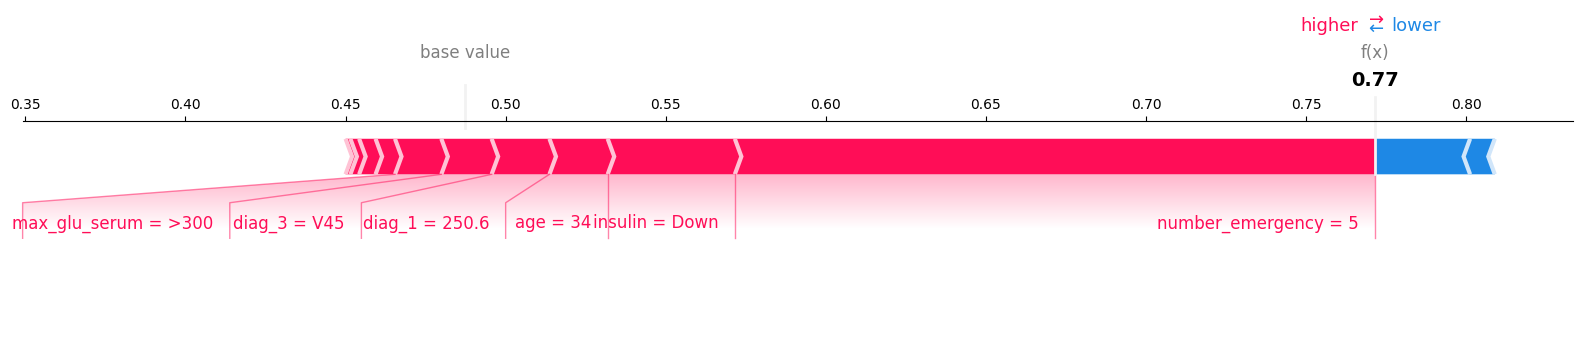

In [ ]:
row_index = 30399
single_datapoint = df_test[df_test.index==row_index]
# single_prediction = ag_wrapper.predict_binary_prob(single_datapoint)
helper.single_point_explainer(100, single_datapoint, explainer)

#### Most confident data point for negative readmittance.
#### Largest negative contributing factor is 'age'=1, followed by 'number_diagnoses'=1, and so forth, while positive contributing factors are much lower.

  0%|          | 0/1 [00:00<?, ?it/s]

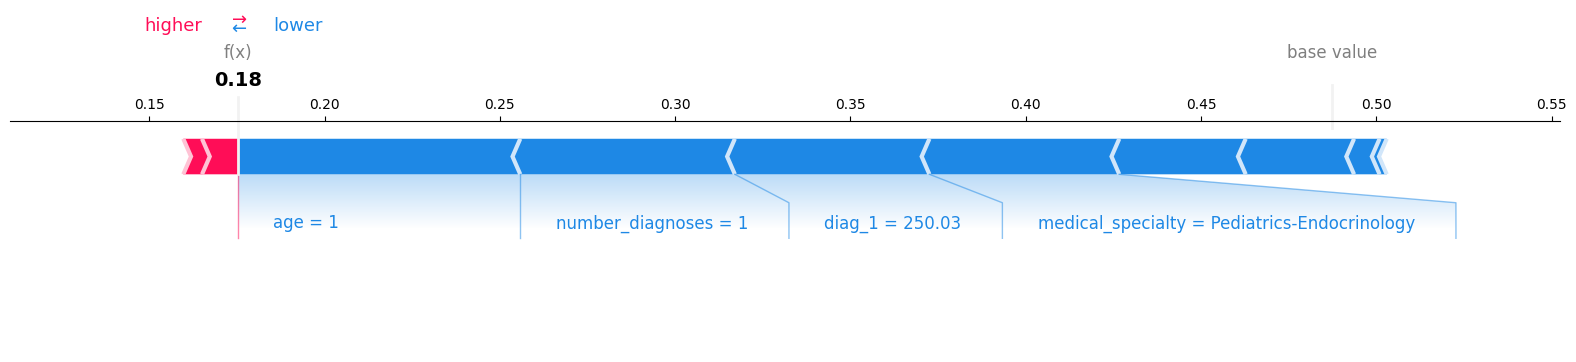

In [ ]:
row_index = 3766
single_datapoint = df_test[df_test.index==row_index]
# single_prediction = ag_wrapper.predict_binary_prob(single_datapoint)
helper.single_point_explainer(100, single_datapoint, explainer)

#### Least confident data point for readmittance.
#### Top positive contributing factors are 'discharge_disposition_id'=3 (transfer to SNF) and 'num_medications'=19 are countered by the negative contributing factors 'diag_1'=733 and 'diabetesMed'=No. These counteracting factors cancel each other out such that there is low confidence to determine readmittance.

  0%|          | 0/1 [00:00<?, ?it/s]

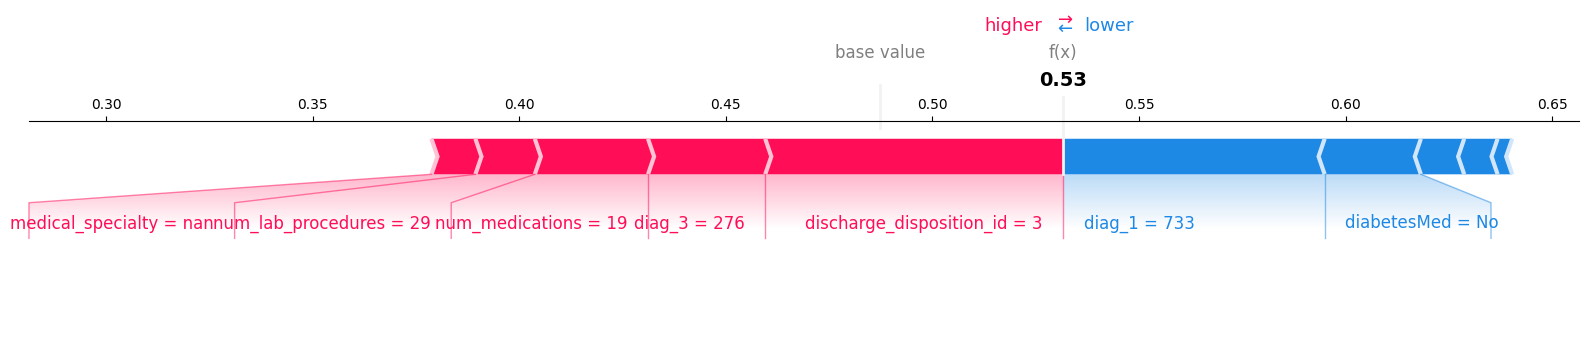

In [ ]:
row_index = 56367
single_datapoint = df_test[df_test.index==row_index]
# single_prediction = ag_wrapper.predict_binary_prob(single_datapoint)
helper.single_point_explainer(100, single_datapoint, explainer)

## 3. Conclusions and improvements

### 3.1 Conclusions
#### 1. The predictive model is able to reduce the real-world readmittance rate by half, from 11.34% to 5.2%.
#### Of all the encounters, 27% that undergo additional discharge plan following the recommendation of ensemble model are unnecessary which may lead to wasted resources. Further analysis to factor in savings in halving the costs of penalities compared to increase costs in 27% addition discharge plans is required.
&nbsp;
#### 2. Factors that may contribute positively towards positive readmittance:
#### * Patients transferred to SNF and home with heath service, and especially those transferred to another rehab.
#### * Patients with 15 more more medications.
#### * Patients with still fluctuating insulin dosages.
#### * Male patients.
&nbsp;
#### 3. Factors that may contribute negatively towards positive readmittance:
#### * Patients with outpatient care.
#### * Patients younger than 60 years may have a lower contributing factor towards positive readmittance than 70 years or older patients. The conversely is not neccessarily true.
&nbsp;

### 3.1 Improvements
#### * Add more features
##### - New diagnosis on readmittance - different unrelated illness? related but further progressed? same problem?
##### - Patient followed prescribled homecare - regularly take medication? occasionally? rarely?
##### - Some feature engineering of number of emergencies and outpatients - ratio.
##### - More comorrbities - e.g. diag_4, diag_5.
&nbsp;
#### * Model improvements
##### - Adjust probability threshold that determines readmittance.
##### - Augment training dataset class balance by skewing towards a larger negative class to try to lower False Positive.
##### - Run AutoGluon with a higher quality setting to train on more base models and expand the hyperparameter space for more accurate fine tuning.
&nbsp;
#### * Perform recursive feature elimination
##### - Systematically evaluate each feature for their contribution.
&nbsp;